In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak
import seaborn as sns
import analysis as ana
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, MinMaxScaler, LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.datasets import make_hastie_10_2
from pandas.api.types import is_float_dtype, is_integer_dtype
from math import ceil, log2
from scipy.special import softmax
import shap
from pathlib import Path
from itertools import cycle
from matplotlib.lines import Line2D
import matplotlib as mpl
import mplhep as mh
mh.style.use("CMS")

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-pac

In [2]:
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"

In [36]:
# Photon files
photon_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_gen.h5"
photon_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_Ref.h5"
photon_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p0113.h5"
photon_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p016.h5"
photon_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p03.h5"
photon_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p045.h5"

# QCD files
qcd_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_gen.h5"
qcd_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_Ref.h5"
qcd_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p0113.h5"
qcd_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p016.h5"
qcd_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p03.h5"
qcd_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p045.h5"

# Pion files
pion_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_gen.h5"
pion_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_Ref.h5"
pion_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p0113.h5"
pion_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p016.h5"
pion_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p03.h5"
pion_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p045.h5"

# PU200 files
PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_Ref.h5"
PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p0113.h5"
PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p016.h5"
PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p03.h5"
PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p045.h5"

In [23]:
photon_PU200_gen_df = pd.read_hdf(photon_PU200_gen)

In [25]:
photon_df_Ref = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_Ref)
photon_df_p0113 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p0113)
photon_df_p016 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p016)
photon_df_p03 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p03)
photon_df_p045 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p045)

In [37]:
qcd_df_Ref = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_Ref)
qcd_df_p0113 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p0113)
qcd_df_p016 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p016)
qcd_df_p03 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p03)
qcd_df_p045 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p045)

In [44]:
pion_df_Ref = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_Ref)
pion_df_p0113 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p0113)
pion_df_p016 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p016)
pion_df_p03 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p03)
pion_df_p045 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p045)

In [50]:
PU_df_Ref = pd.read_hdf(PU200_cl3d_Ref)
PU_df_p0113 = pd.read_hdf(PU200_cl3d_p0113)
PU_df_p016 = pd.read_hdf(PU200_cl3d_p016)
PU_df_p03 = pd.read_hdf(PU200_cl3d_p03)
PU_df_p045 = pd.read_hdf(PU200_cl3d_p045)

In [ ]:
def filter_by_delta_r(df, prefix):
    required_columns = [f"{prefix}_eta", f"{prefix}_phi", "genpart_exeta", "genpart_exphi", f"{prefix}_energy", "event", "gen_pt",]
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")
    df = df.copy()
    m_sign = (df[f"{prefix}_eta"] * df["genpart_exeta"]) > 0.0
    df = df[m_sign]
    df["delta_r"] = ana.delta_r(
        df[f"{prefix}_eta"], df[f"{prefix}_phi"],
        df["genpart_exeta"], df["genpart_exphi"]
    )
    # build per-row ΔR threshold
    if prefix in ["cl3d_Ref", "cl3d_p0113Tri", "cl3d_p016Tri"]:
        dr_thr = 0.10
        m_dr = df["delta_r"] < dr_thr
    elif prefix in ["cl3d_p03Tri", "cl3d_p045Tri"]:
        # gen-pt dependent
        dr_thr_arr = np.where(df["gen_pt"].to_numpy() < 70.0, 0.15, 0.60)
        m_dr = df["delta_r"].to_numpy() < dr_thr_arr
    else:
        raise ValueError(f"Unknown prefix '{prefix}' for ΔR threshold rules")
    df_filtered = df[m_dr]
    # best match per event: highest energy, then smallest ΔR
    df_sorted = df_filtered.sort_values(
        by=["event", f"{prefix}_energy", "delta_r"],
        ascending=[True, False, True]
    )
    df_best_match = df_sorted.groupby("event").first().reset_index()
    return df_best_match

In [11]:
pd.set_option("display.min_rows", 50)
pd.set_option("display.max_columns", 50)

Ref: n0=3097
p0113: n0=3097
p016: n0=3097
p03: n0=3097
p045: n0=3097


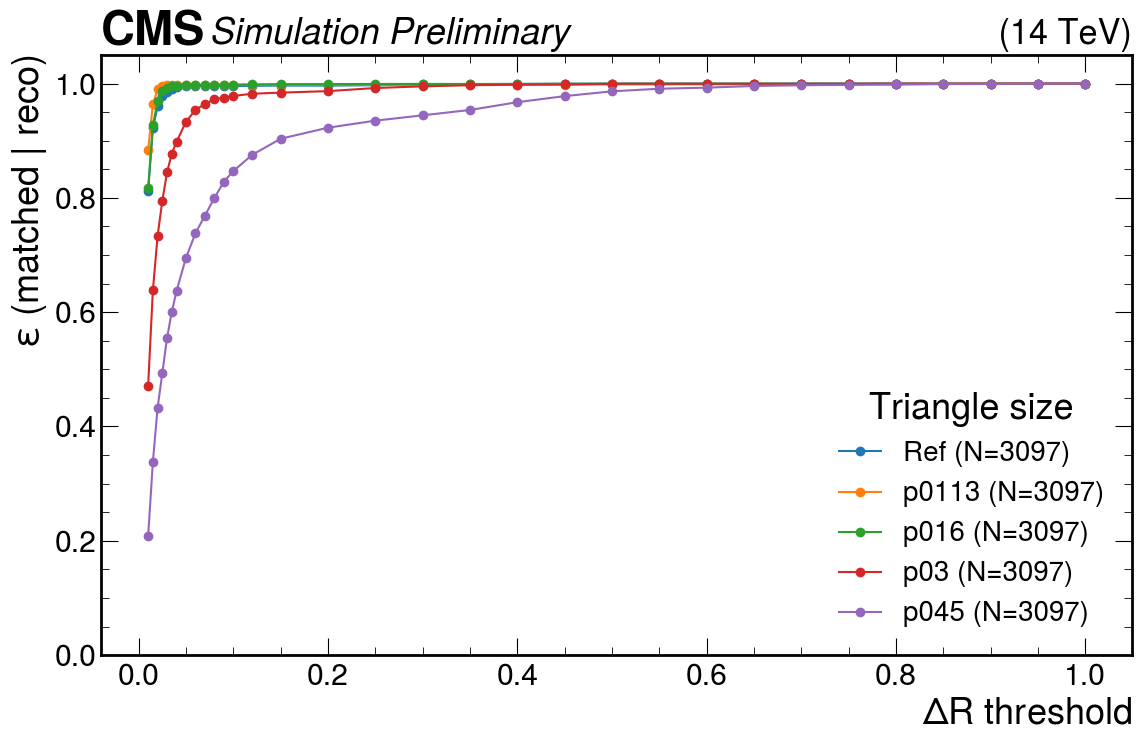

In [66]:
# Your dfs
dfs = {
    "Ref":   (pion_df_Ref,   "cl3d_Ref"),
    "p0113": (pion_df_p0113, "cl3d_p0113Tri"),
    "p016":  (pion_df_p016,  "cl3d_p016Tri"),
    "p03":   (pion_df_p03,   "cl3d_p03Tri"),
    "p045":  (pion_df_p045,  "cl3d_p045Tri"),
}

dr_vals = np.array([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.12, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])

plt.figure(figsize=(12, 8))

for label, (df, prefix) in dfs.items():
    n0 = df["event"].nunique()  # baseline events (reco exists etc. as in your df)
    eff = []

    for dr in dr_vals:
        df_cut = ana.filter_by_delta_r(df, prefix, dr)
        n_pass = df_cut["event"].nunique()   # <-- event-based numerator
        eff.append(n_pass / n0 if n0 > 0 else 0.0)

    eff = np.array(eff)

    print(f"{label}: n0={n0}")
    # optional: print some numbers
    # for d, e in zip(dr_vals, eff): print(label, d, e)

    plt.plot(dr_vals, eff, marker="o", label=f"{label} (N={n0})")

plt.xlabel(r"$\Delta R$ threshold")
plt.ylabel(r"$\epsilon$ (matched | reco)")
plt.ylim(0, 1.05)
plt.legend(title="Triangle size", fontsize=20)
mh.cms.label("Preliminary", data=False, com=14)
plt.tight_layout()
plt.savefig("eff_vs_deltaR_allTriangles_pion.png", dpi=200)
plt.show()

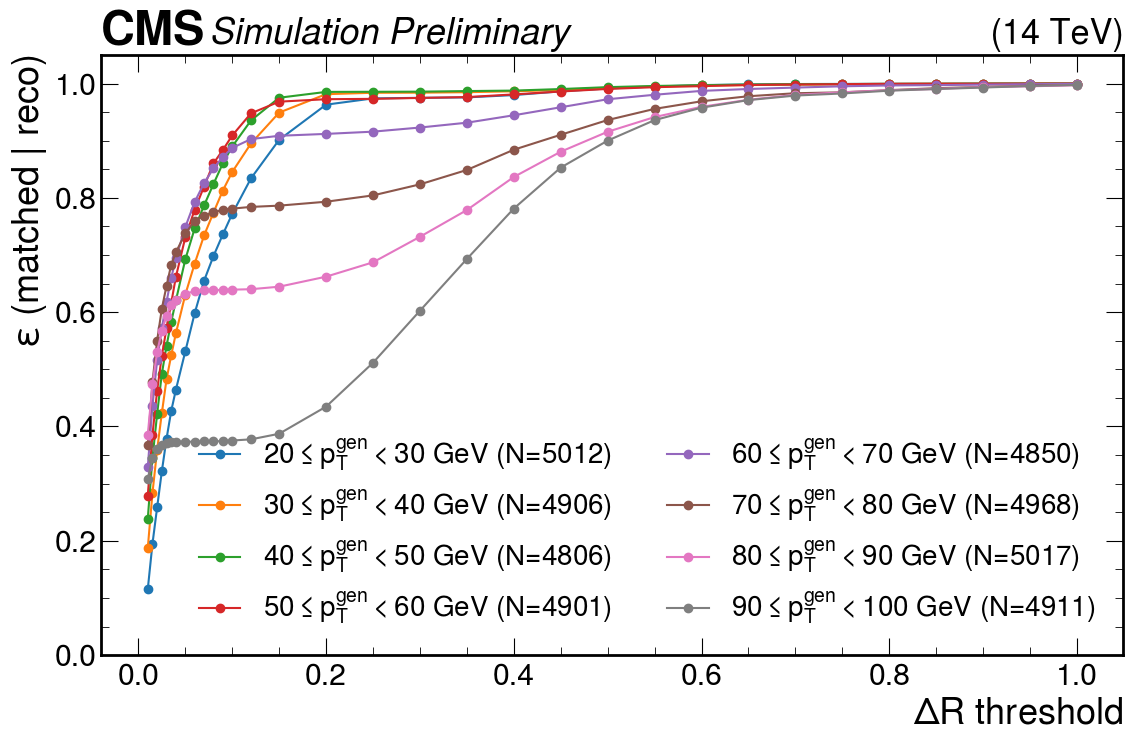

In [ ]:
pt_bins = np.array([20, 30, 40, 50, 60, 70, 80, 90, 100])  # edit to taste
eff_map = np.zeros((len(pt_bins)-1, len(dr_vals)), dtype=float)
n0_bins = np.zeros(len(pt_bins)-1, dtype=int)

for ib in range(len(pt_bins)-1):
    lo, hi = pt_bins[ib], pt_bins[ib+1]

    df_bin = photon_df_p045[(photon_df_p045["gen_pt"] >= lo) & (photon_df_p045["gen_pt"] < hi)]

    n0 = df_bin["event"].nunique()
    n0_bins[ib] = n0

    if n0 == 0:
        continue

    for idr, dr in enumerate(dr_vals):
        df_cut = ana.filter_by_delta_r(df_bin, "cl3d_p045Tri", dr)
        n_pass = df_cut["event"].nunique()
        eff_map[ib, idr] = n_pass / n0

# ---- plot curves ----
plt.figure(figsize=(12,8))
for ib in range(len(pt_bins)-1):
    lo, hi = pt_bins[ib], pt_bins[ib+1]
    plt.plot(dr_vals, eff_map[ib], marker="o",
             label=rf"${lo:g}\leq p_T^{{gen}}<{hi:g}$ GeV (N={n0_bins[ib]})")

plt.xlabel(r"$\Delta R$ threshold")
plt.ylabel(r"$\epsilon$ (matched | reco)")
plt.ylim(0, 1.05)
plt.legend(ncol=2, fontsize=20)
mh.cms.label("Preliminary", data=False, com=14)
plt.tight_layout()
plt.savefig("eff_vs_deltaR_by_genPt_qcd.png", dpi=200)
plt.show()

In [69]:
photon_df_Ref_filtered = filter_by_delta_r(photon_df_Ref, "cl3d_Ref")
photon_df_p0113_filtered = filter_by_delta_r(photon_df_p0113, "cl3d_p0113Tri")
photon_df_p016_filtered = filter_by_delta_r(photon_df_p016, "cl3d_p016Tri")
photon_df_p03_filtered = filter_by_delta_r(photon_df_p03, "cl3d_p03Tri")
photon_df_p045_filtered = filter_by_delta_r(photon_df_p045, "cl3d_p045Tri")

In [70]:
def plot_across_five_lists(
    df_ref, df_p0113, df_p016, df_p03, df_p045,
    vars_ref, vars_p0113, vars_p016, vars_p03, vars_p045,
    label_ref="Ref", label_p0113="p=0.113", label_p016="p=0.16", label_p03="p=0.30", label_p045="p=0.45",
    plots_dir="plots_triangles", var_latex_map=None, num_bins=40, cl3d_pt_range=(20, 200),
    pt_col_ref="cl3d_Ref_pt", pt_col_p0113="cl3d_p0113Tri_pt", pt_col_p016="cl3d_p016Tri_pt",
    pt_col_p03="cl3d_p03Tri_pt", pt_col_p045="cl3d_p045Tri_pt",
    density=False, logy=False, weight_cols=None
):
    os.makedirs(plots_dir, exist_ok=True)
    if var_latex_map is None:
        var_latex_map = {}
    suffix_labels = ana.var_map_suffix()
    # Build maps: suffix -> full col name (for each DF)
    def suffix(name): 
        return name.split("_", maxsplit=2)[-1] if name.count("_")>=2 else name

    by_suffix = {"ref":{}, "p0113":{}, "p016":{}, "p03":{}, "p045":{}}
    for c in vars_ref:  by_suffix["ref"][suffix(c)]  = c
    for c in vars_p0113: by_suffix["p0113"][suffix(c)] = c
    for c in vars_p016: by_suffix["p016"][suffix(c)] = c
    for c in vars_p03:  by_suffix["p03"][suffix(c)]  = c
    for c in vars_p045: by_suffix["p045"][suffix(c)] = c

    # Union of all suffixes to try plotting
    all_suffixes = list(dict.fromkeys(
        list(by_suffix["ref"].keys()) +
        list(by_suffix["p0113"].keys()) +
        list(by_suffix["p016"].keys()) +
        list(by_suffix["p03"].keys()) +
        list(by_suffix["p045"].keys())
    ))

    # Helper to get (series, weights) after pT window for a given variant
    def select(df, col, pt_col, wcol):
        if (col not in df.columns) or (pt_col not in df.columns): 
            return pd.Series(dtype=float), None
        m = (df[pt_col] >= cl3d_pt_range[0]) & (df[pt_col] <= cl3d_pt_range[1])
        ser = df.loc[m, col].dropna()
        w = (df.loc[m, wcol] if (wcol and wcol in df.columns) else None)
        if w is not None: w = w.loc[ser.index]
        return ser, w

    # Iterate each suffix (i.e., each physics variable)
    for suf in all_suffixes:
        cols = {
            "ref":  by_suffix["ref"].get(suf,  None),
            "p0113": by_suffix["p0113"].get(suf, None),
            "p016": by_suffix["p016"].get(suf, None),
            "p03":  by_suffix["p03"].get(suf,  None),
            "p045": by_suffix["p045"].get(suf, None),
        }

        # Gather data
        s_ref,  w_ref  = select(df_ref,  cols["ref"],  pt_col_ref,  (weight_cols or {}).get("ref"))
        s_p0113, w_p0113 = select(df_p0113, cols["p0113"], pt_col_p0113, (weight_cols or {}).get("p0113"))
        s_p016, w_p016 = select(df_p016, cols["p016"], pt_col_p016, (weight_cols or {}).get("p016"))
        s_p03,  w_p03  = select(df_p03,  cols["p03"],  pt_col_p03,  (weight_cols or {}).get("p03"))
        s_p045, w_p045 = select(df_p045, cols["p045"], pt_col_p045, (weight_cols or {}).get("p045"))

        series_list = [s for s in [s_ref, s_p0113, s_p016, s_p03, s_p045] if not s.empty]
        if not series_list:
            print(f"[skip] No data for '{suf}' after pT filter.")
            continue

        # Binning: integer bins if all are integer-like, else uniform numeric bins
        mins = [s.min() for s in series_list]
        maxs = [s.max() for s in series_list]
        all_int = all(is_integer_dtype(s) for s in series_list)
        gmin, gmax = float(np.min(mins)), float(np.max(maxs))
        if all_int and np.isfinite(gmin) and np.isfinite(gmax):
            bin_edges = np.arange(np.floor(gmin)-0.5, np.ceil(gmax)+1.5, 1.0)
        else:
            if gmin == gmax:
                gmin -= 0.5; gmax += 0.5
            bw = (gmax - gmin) / float(num_bins)
            bin_edges = np.arange(gmin - bw/2, gmax + bw/2 + 1e-12, bw)

        # Plot
        plt.figure(figsize=(10,6))
        if not s_ref.empty:
            plt.hist(s_ref.values,  bins=bin_edges, histtype="step", label=label_ref,  density=density, weights=(w_ref.values if w_ref is not None else None))
        if not s_p0113.empty:
            plt.hist(s_p0113.values, bins=bin_edges, histtype="step", label=label_p0113, density=density, weights=(w_p0113.values if w_p0113 is not None else None))
        if not s_p016.empty:
            plt.hist(s_p016.values, bins=bin_edges, histtype="step", label=label_p016, density=density, weights=(w_p016.values if w_p016 is not None else None))
        if not s_p03.empty:
            plt.hist(s_p03.values,  bins=bin_edges, histtype="step", label=label_p03,  density=density, weights=(w_p03.values if w_p03 is not None else None))
        if not s_p045.empty:
            plt.hist(s_p045.values, bins=bin_edges, histtype="step", label=label_p045, density=density, weights=(w_p045.values if w_p045 is not None else None))

        # Labels
        sample_full = next((c for c in [cols["ref"], cols["p0113"], cols["p016"], cols["p03"], cols["p045"]] if c is not None), None)
        suf_label   = suffix_labels.get(suf)  # e.g. 'pt' -> '$p_T$ [GeV]'
        x_label     = suf_label or (var_latex_map or {}).get(sample_full, suf)
        plt.xlabel(x_label)
        plt.yscale('log')
        plt.ylabel("# Clusters")
        plt.legend(loc='best')
        plt.tight_layout()
        fig = plt.gcf()
        mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit
        out = os.path.join(plots_dir, f"{suf}_across_triangles.pdf")
        plt.savefig(out)
        print(f"Saved: {out}")
        plt.show()
        plt.close()

Saved: plot_triangles_genmatched/pt_across_triangles.pdf


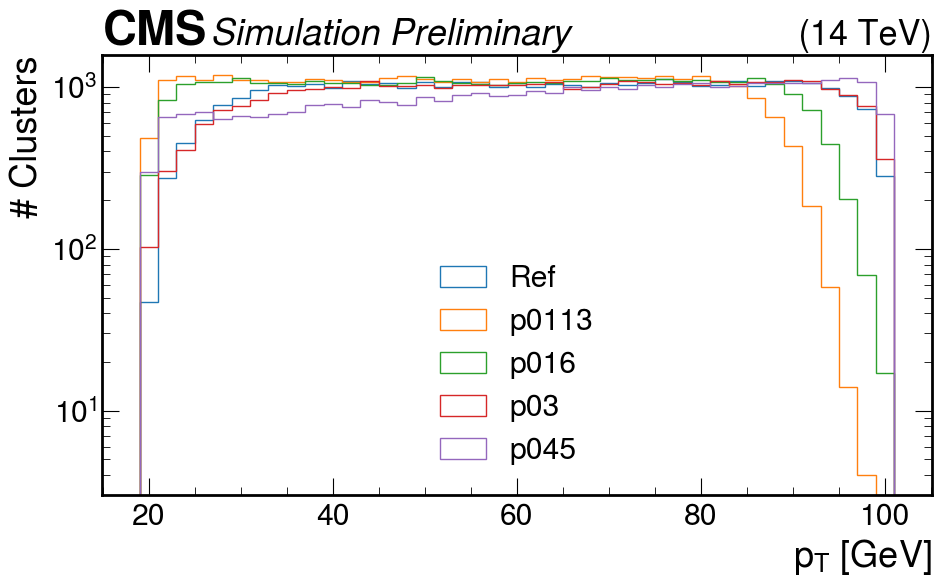

Saved: plot_triangles_genmatched/energy_across_triangles.pdf


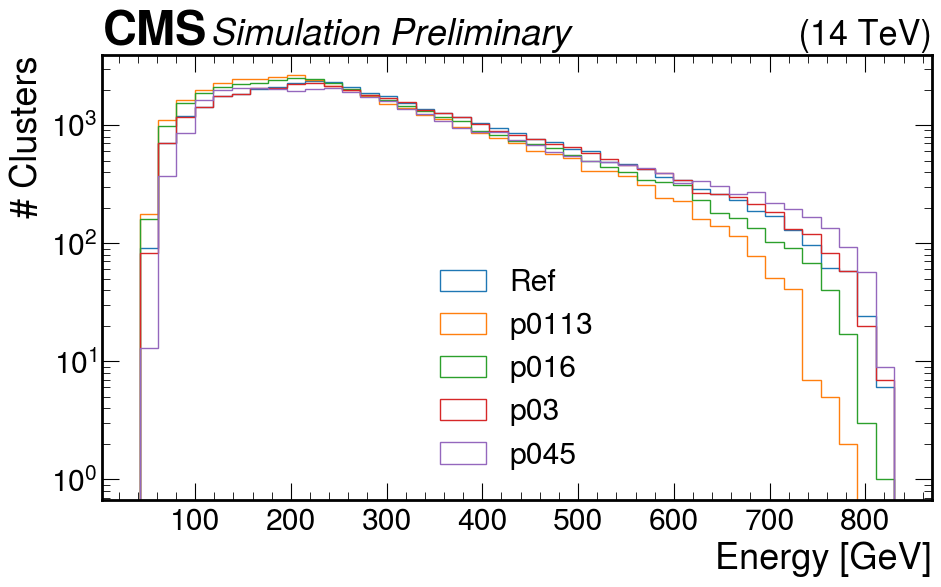

Saved: plot_triangles_genmatched/eta_across_triangles.pdf


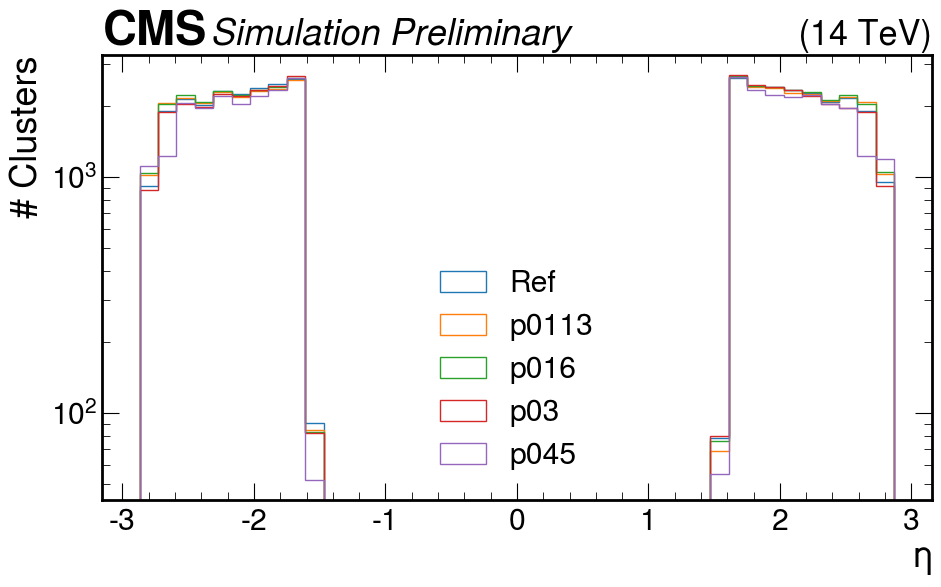

Saved: plot_triangles_genmatched/phi_across_triangles.pdf


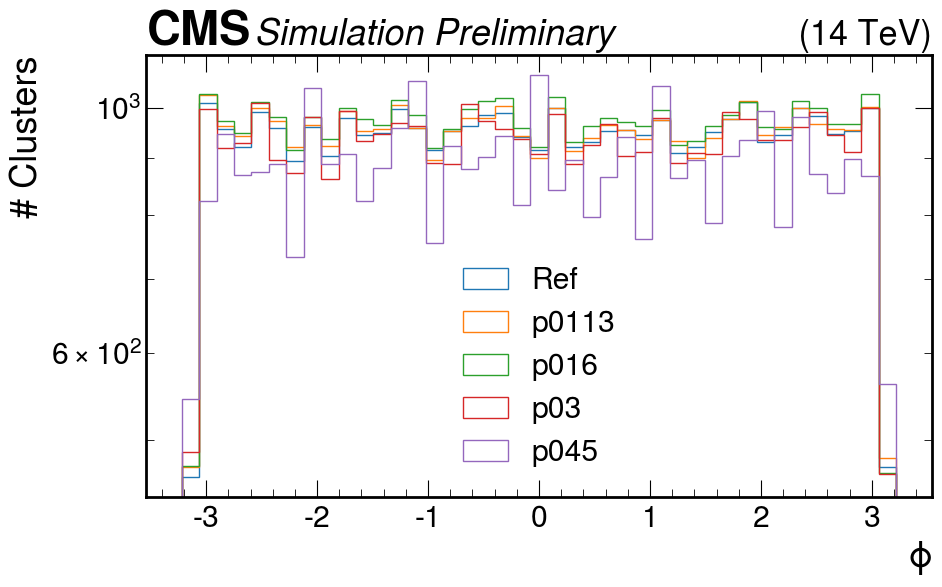

Saved: plot_triangles_genmatched/emax1layers_across_triangles.pdf


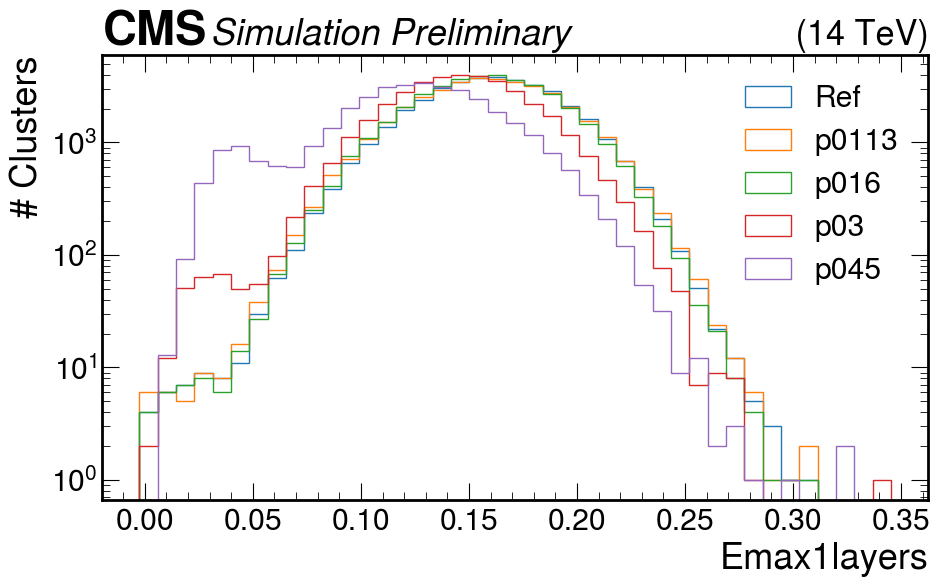

Saved: plot_triangles_genmatched/emax3layers_across_triangles.pdf


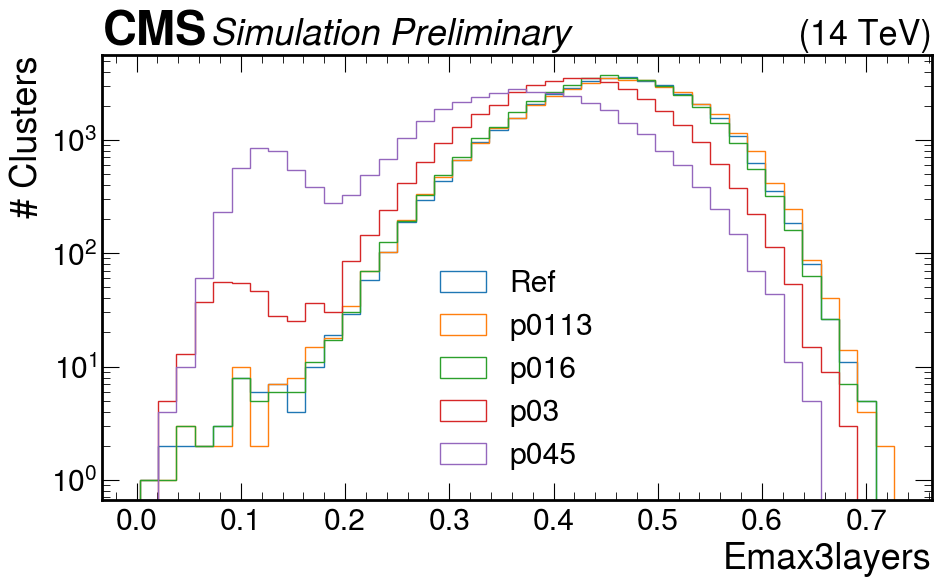

Saved: plot_triangles_genmatched/showerlength_across_triangles.pdf


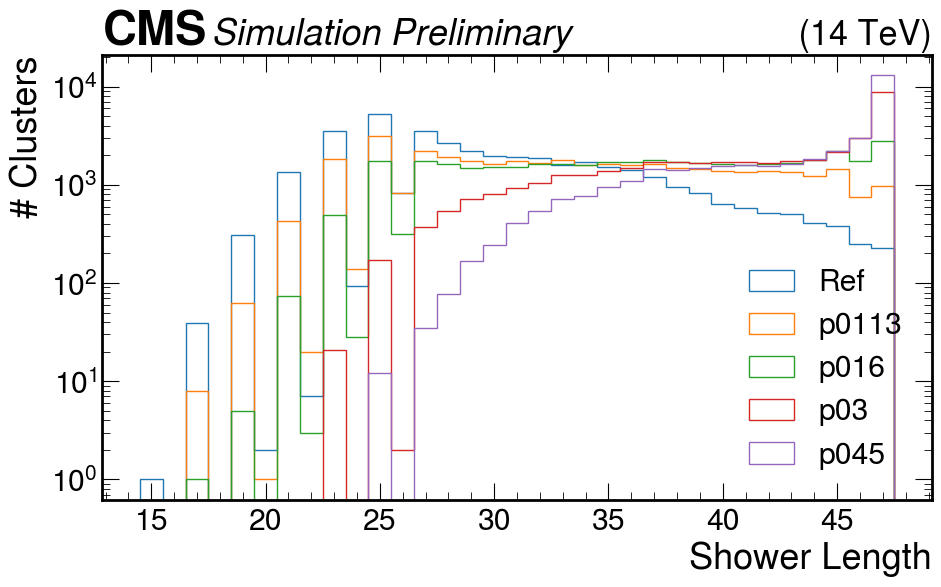

Saved: plot_triangles_genmatched/coreshowerlength_across_triangles.pdf


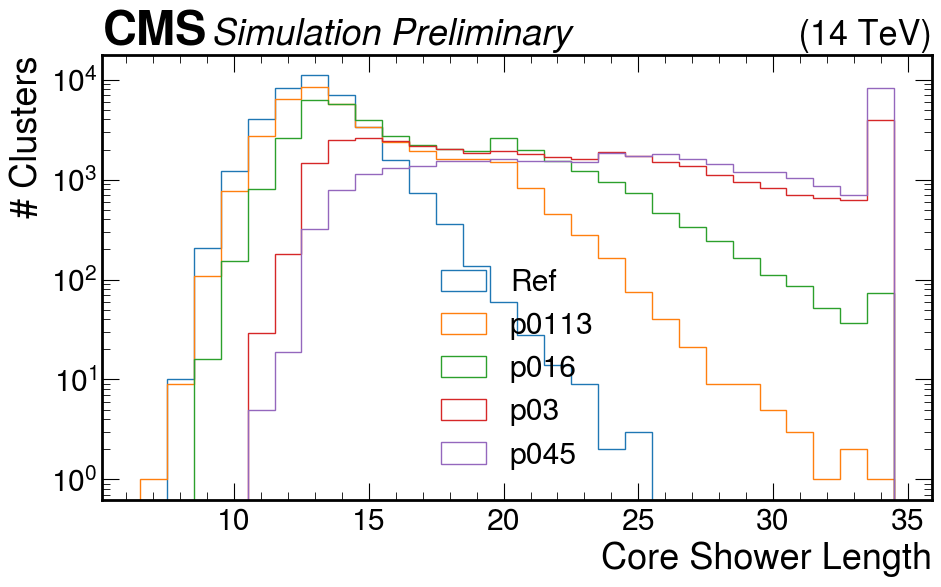

Saved: plot_triangles_genmatched/firstlayer_across_triangles.pdf


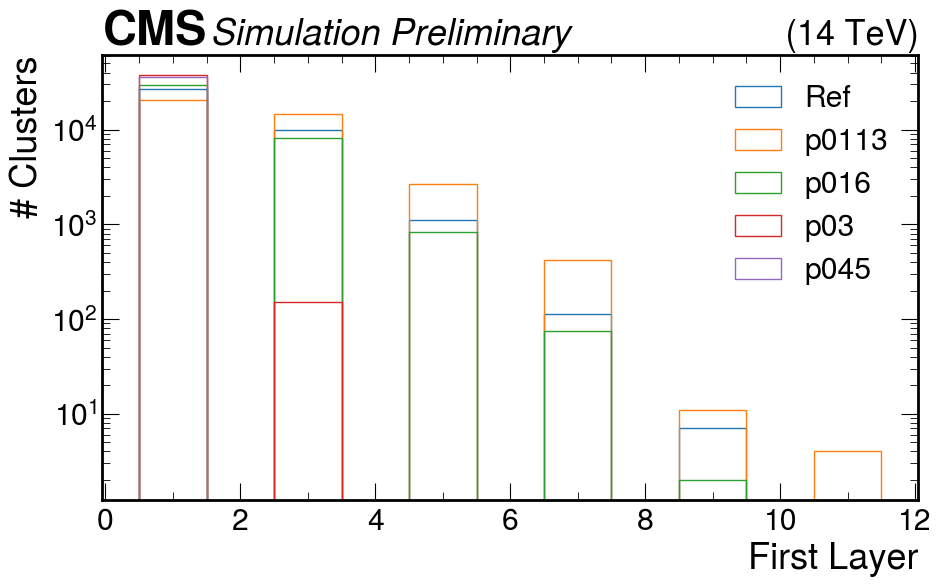

Saved: plot_triangles_genmatched/maxlayer_across_triangles.pdf


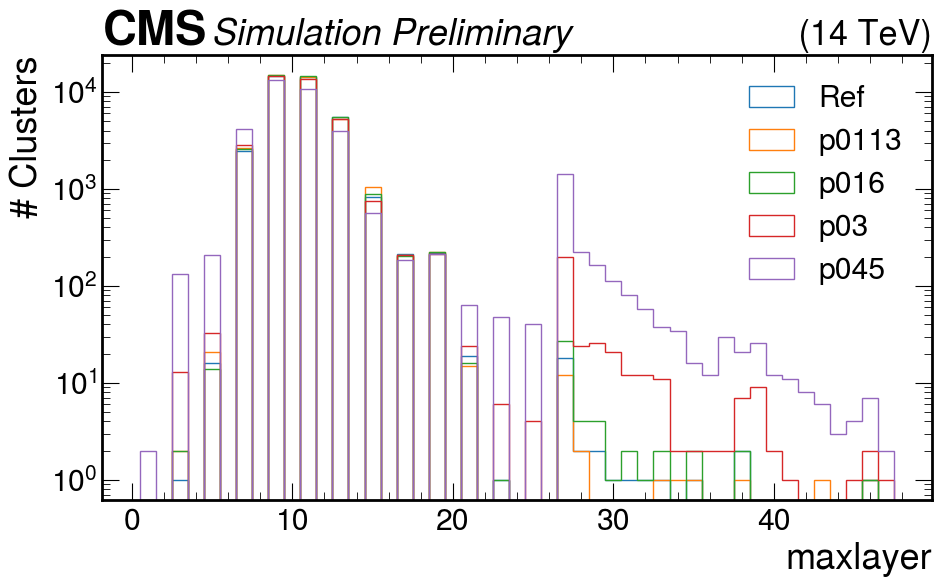

Saved: plot_triangles_genmatched/varrr_across_triangles.pdf


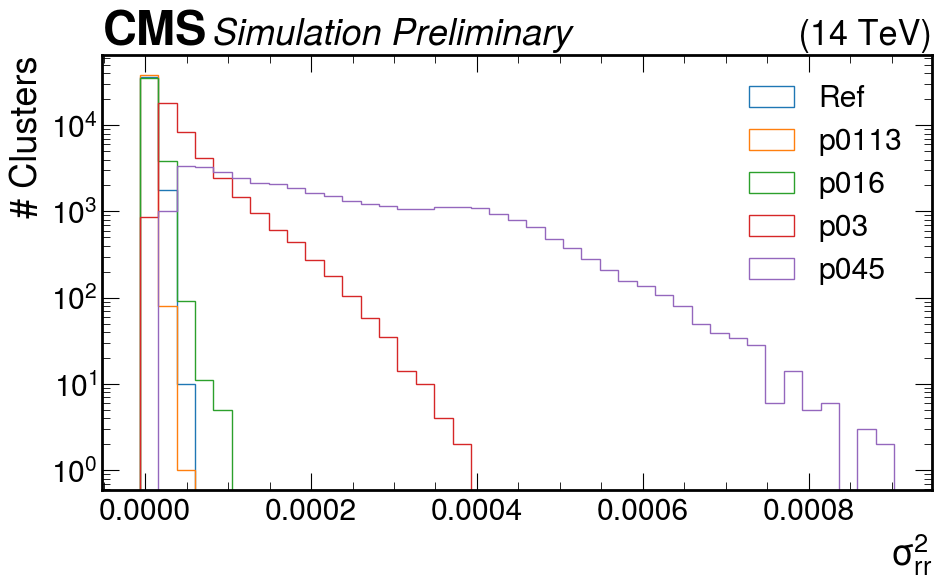

Saved: plot_triangles_genmatched/varzz_across_triangles.pdf


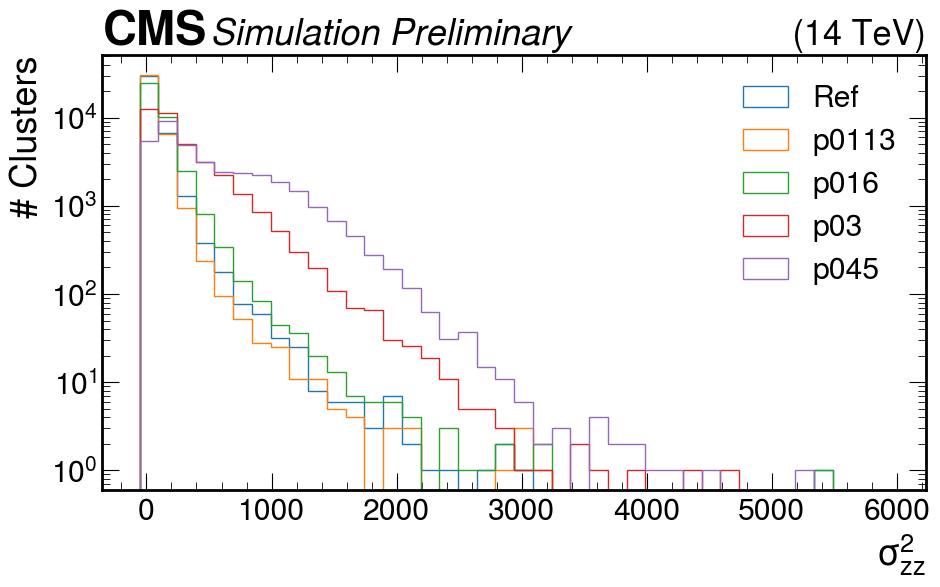

Saved: plot_triangles_genmatched/varee_across_triangles.pdf


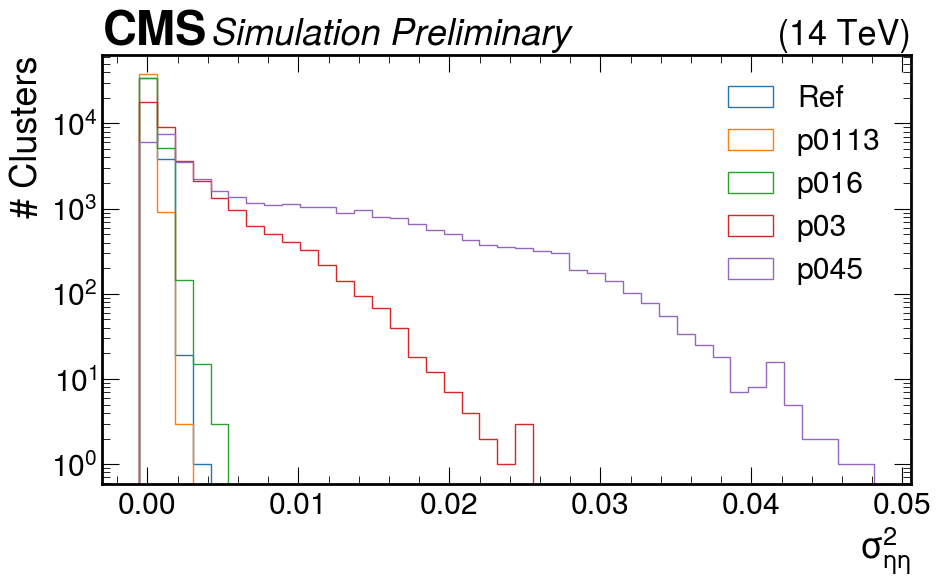

Saved: plot_triangles_genmatched/varpp_across_triangles.pdf


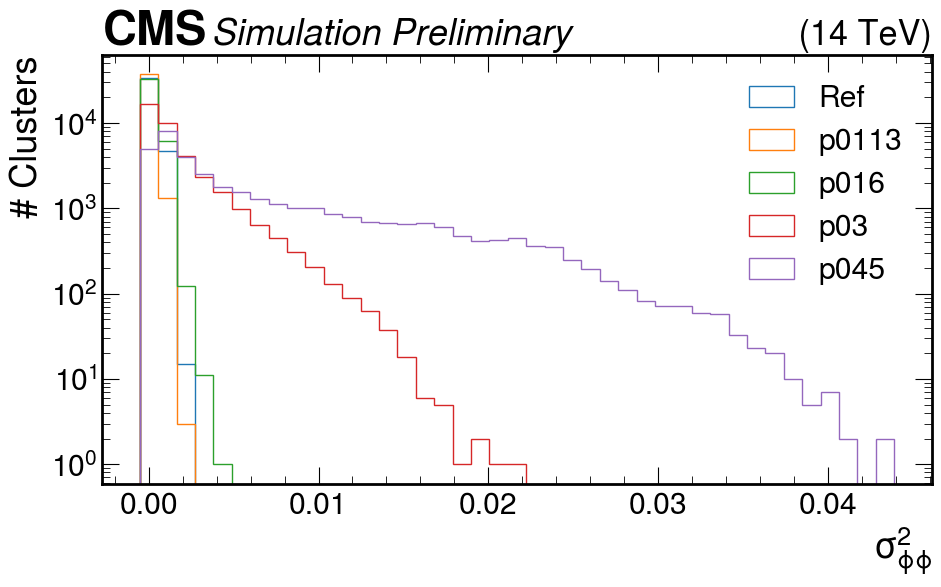

Saved: plot_triangles_genmatched/emaxe_across_triangles.pdf


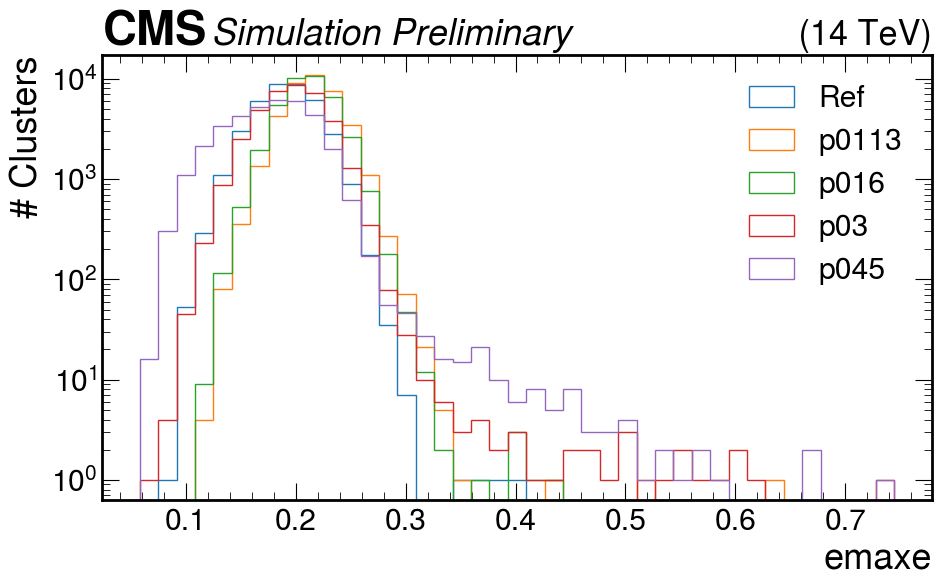

Saved: plot_triangles_genmatched/hoe_across_triangles.pdf


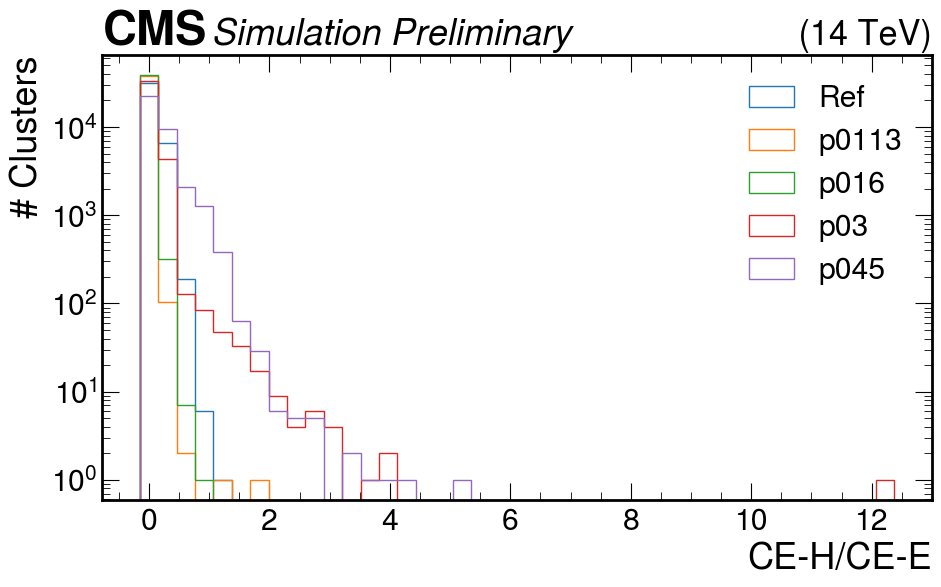

Saved: plot_triangles_genmatched/meanz_across_triangles.pdf


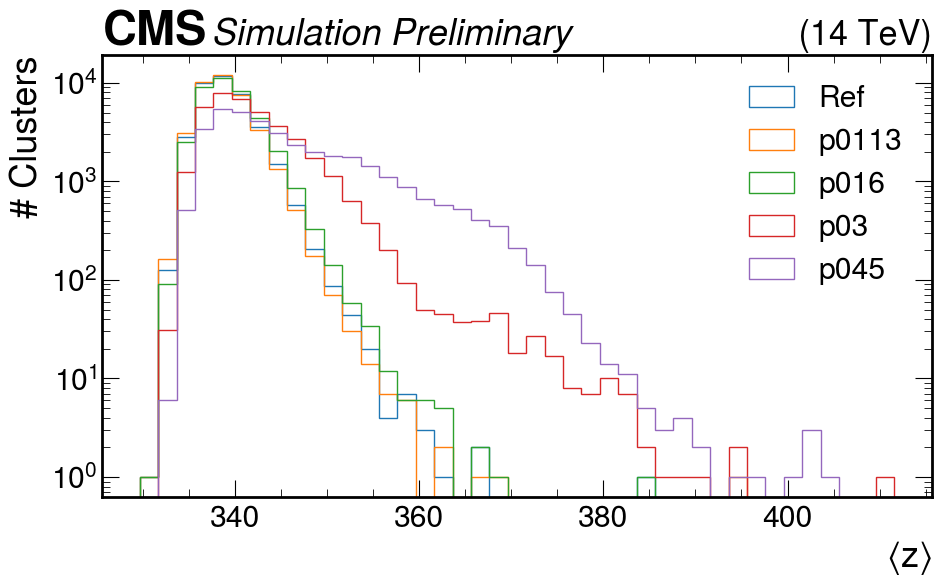

Saved: plot_triangles_genmatched/first1layers_across_triangles.pdf


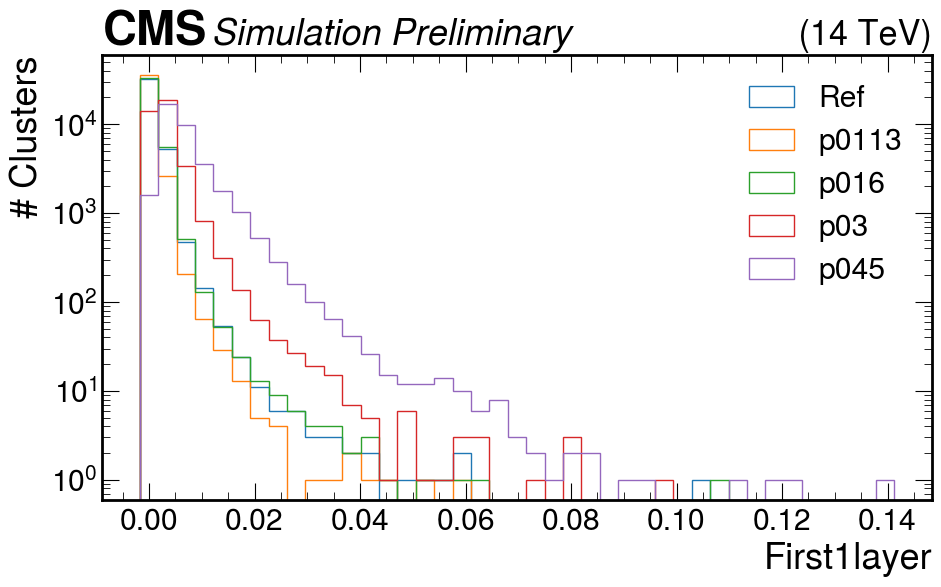

Saved: plot_triangles_genmatched/first3layers_across_triangles.pdf


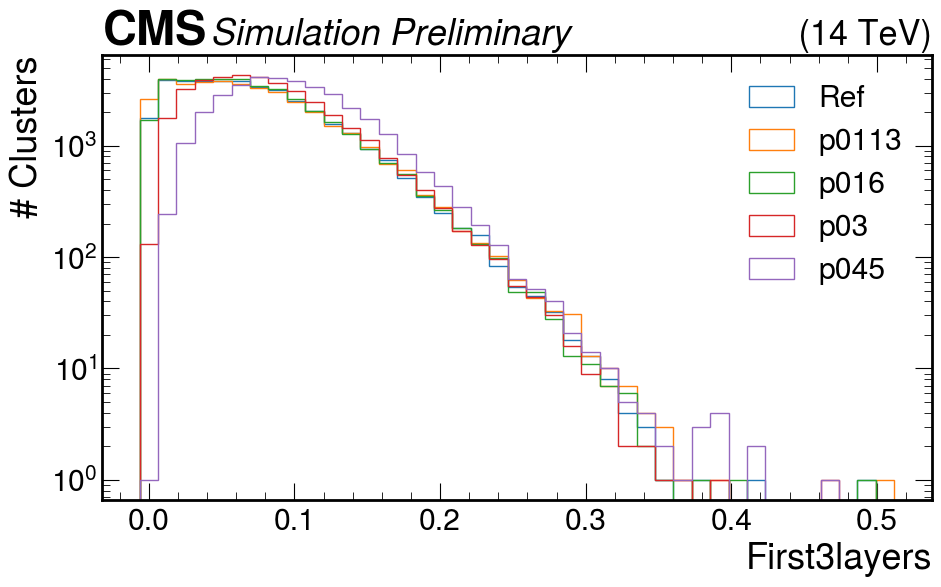

Saved: plot_triangles_genmatched/first5layers_across_triangles.pdf


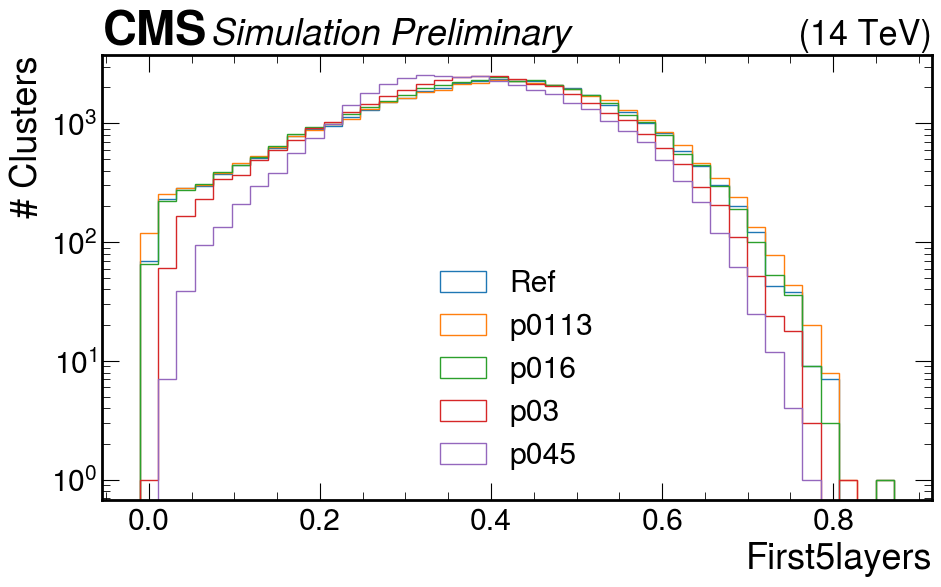

Saved: plot_triangles_genmatched/firstHcal1layers_across_triangles.pdf


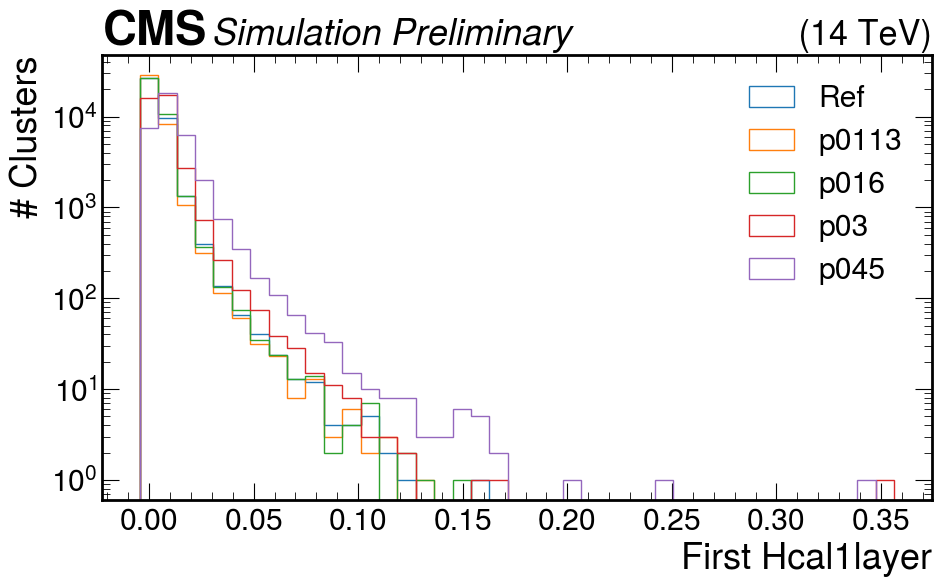

Saved: plot_triangles_genmatched/firstHcal3layers_across_triangles.pdf


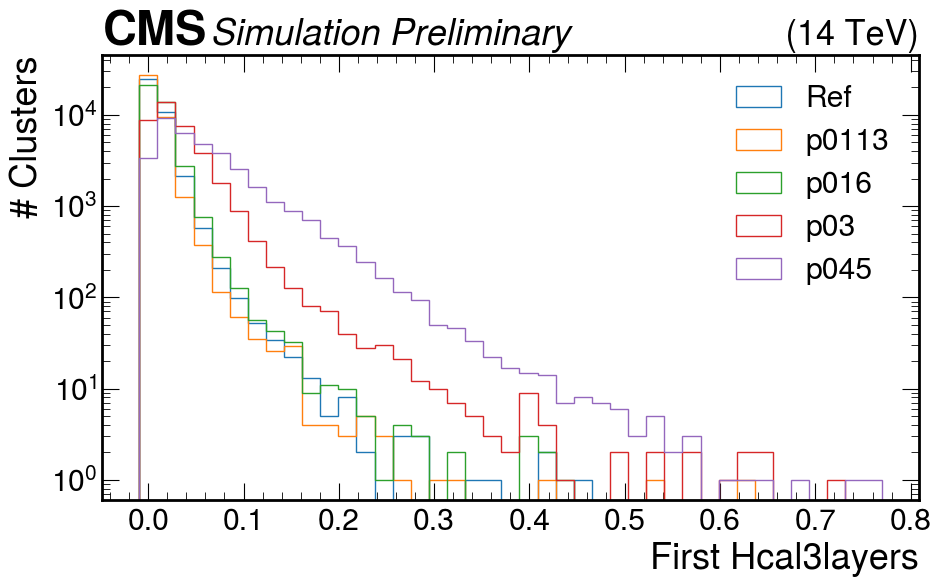

Saved: plot_triangles_genmatched/firstHcal5layers_across_triangles.pdf


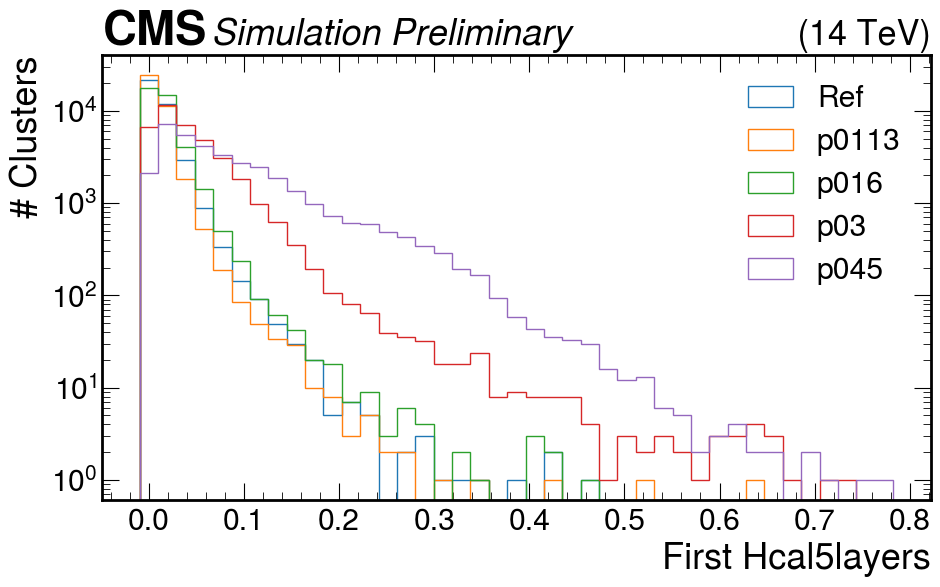

Saved: plot_triangles_genmatched/last1layers_across_triangles.pdf


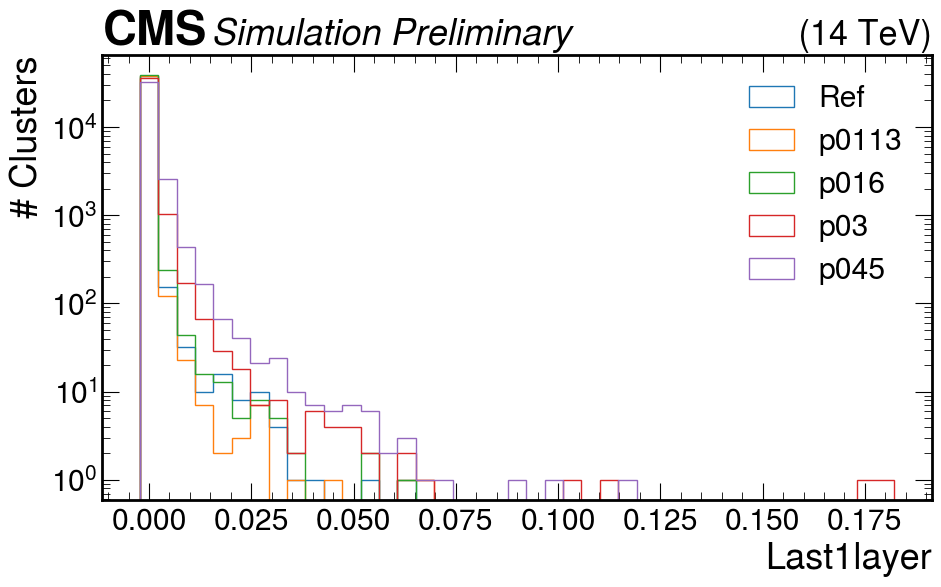

Saved: plot_triangles_genmatched/last3layers_across_triangles.pdf


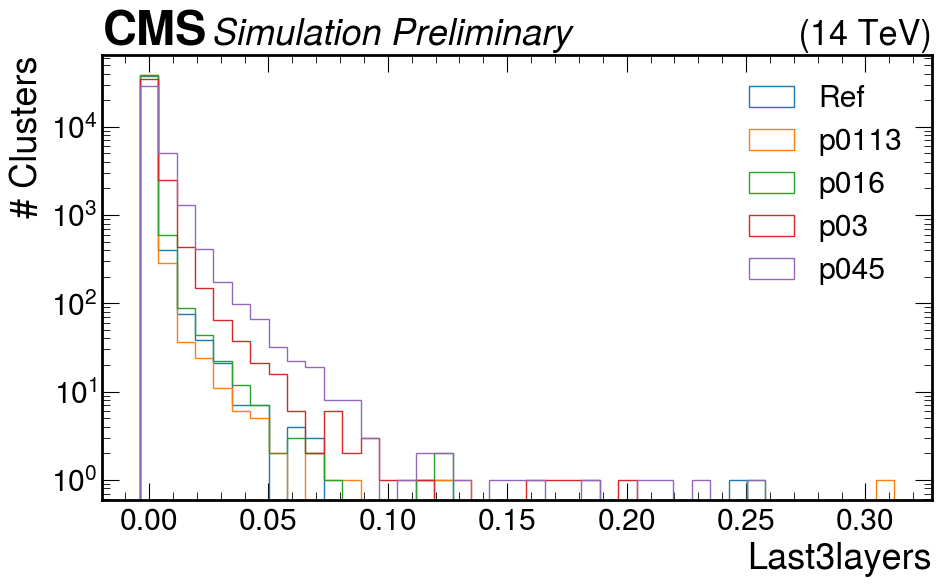

Saved: plot_triangles_genmatched/last5layers_across_triangles.pdf


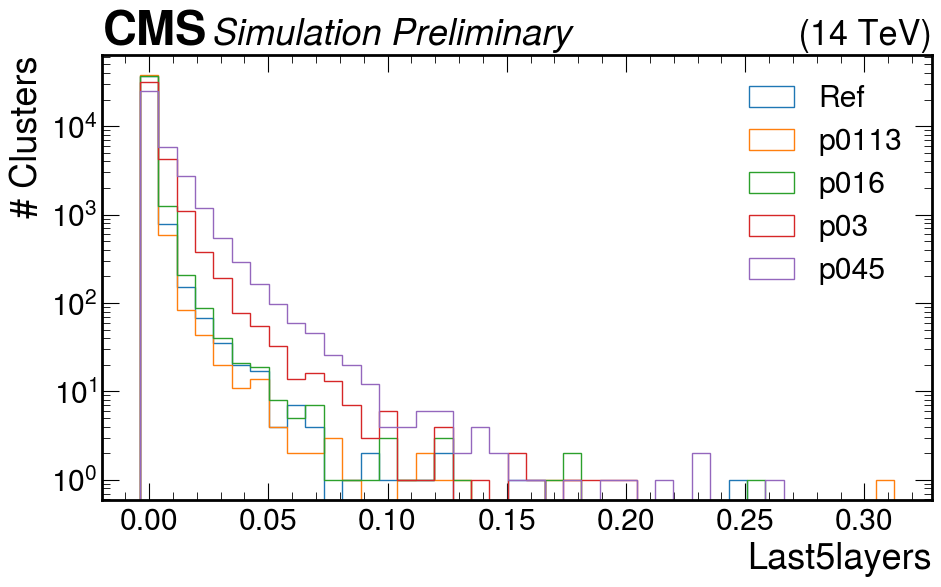

Saved: plot_triangles_genmatched/eot_across_triangles.pdf


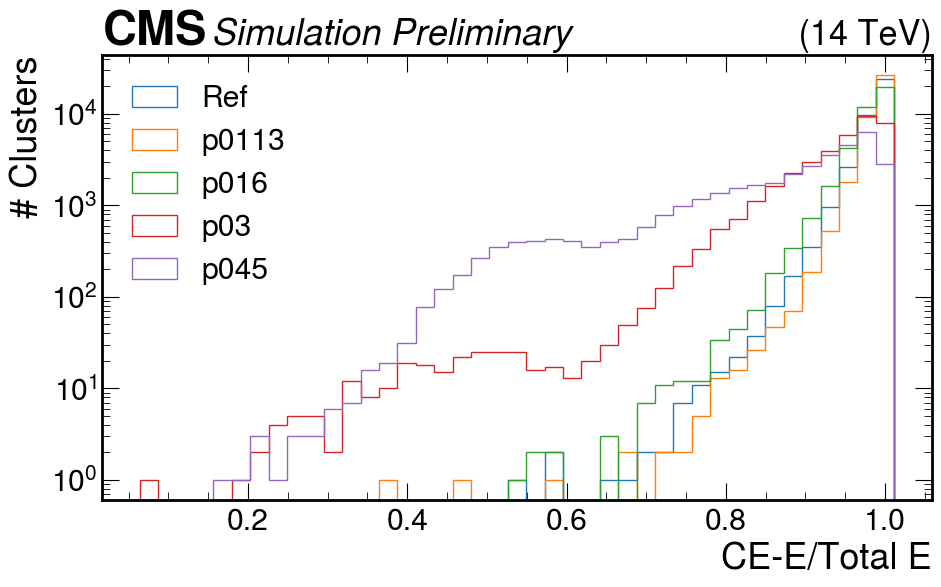

Saved: plot_triangles_genmatched/ebm0_across_triangles.pdf


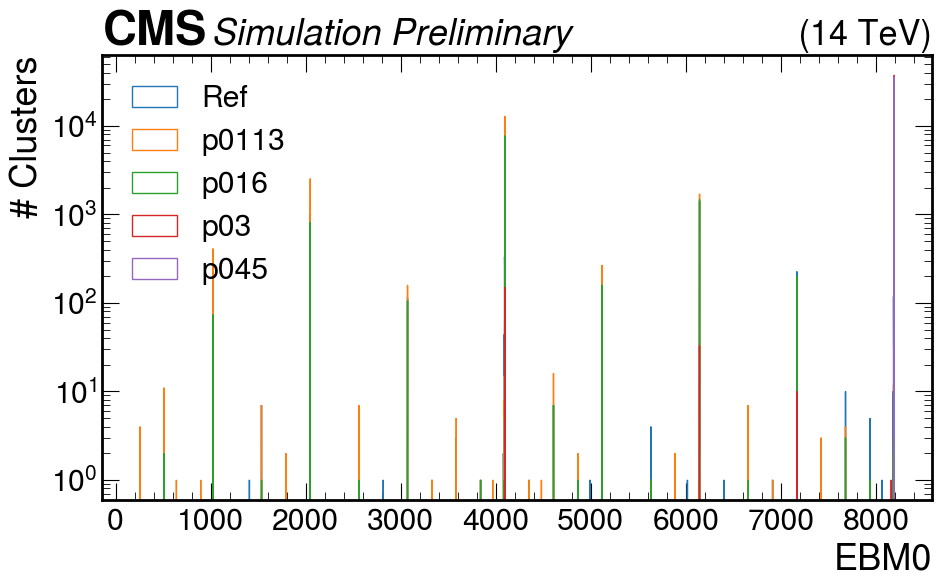

Saved: plot_triangles_genmatched/ebm1_across_triangles.pdf


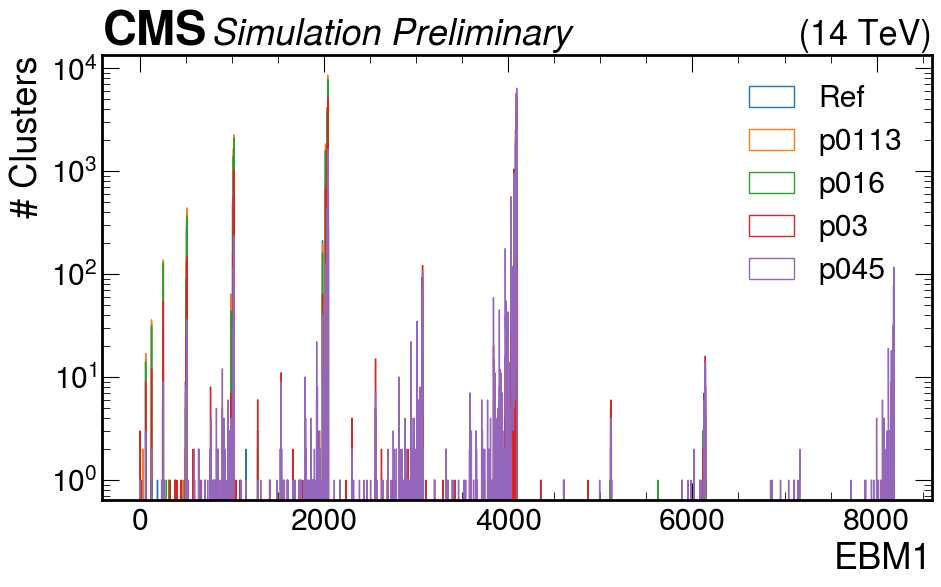

In [71]:
plot_across_five_lists(
    photon_df_Ref_filtered, photon_df_p0113_filtered, photon_df_p016_filtered, photon_df_p03_filtered, photon_df_p045_filtered,
    ana.variables_to_plot('Ref'), ana.variables_to_plot('p0113Tri'), ana.variables_to_plot('p016Tri'), ana.variables_to_plot('p03Tri'), ana.variables_to_plot('p045Tri'),   # full column names per DF
    label_ref="Ref", label_p0113="p0113", label_p016="p016", label_p03="p03", label_p045="p045",
    plots_dir="plot_triangles_genmatched",
    var_latex_map=None,                         # can map full name or suffix
    num_bins=40, cl3d_pt_range=(20, 100),
    pt_col_ref="cl3d_Ref_pt", pt_col_p0113="cl3d_p0113Tri_pt", pt_col_p016="cl3d_p016Tri_pt",
    pt_col_p03="cl3d_p03Tri_pt", pt_col_p045="cl3d_p045Tri_pt",
    density=False, logy=False, weight_cols=None  # weight_cols: dict with keys "ref","p016","p03","p045"
)

In [72]:
PU_df_Ref = pd.read_hdf(PU200_cl3d_Ref)
PU_df_p0113 = pd.read_hdf(PU200_cl3d_p0113)
PU_df_p016 = pd.read_hdf(PU200_cl3d_p016)
PU_df_p03 = pd.read_hdf(PU200_cl3d_p03)
PU_df_p045 = pd.read_hdf(PU200_cl3d_p045)

In [73]:
pion_df_Ref = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_Ref)
pion_df_p0113 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p0113)
pion_df_p016 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p016)
pion_df_p03 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p03)
pion_df_p045 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p045)

In [74]:
# Delta r filter
pion_df_Ref_filtered = ana.filter_by_delta_r(pion_df_Ref, "cl3d_Ref", 0.5)
pion_df_p0113_filtered = ana.filter_by_delta_r(pion_df_p0113, "cl3d_p0113Tri", 0.5)
pion_df_p016_filtered = ana.filter_by_delta_r(pion_df_p016, "cl3d_p016Tri", 0.5)
pion_df_p03_filtered = ana.filter_by_delta_r(pion_df_p03, "cl3d_p03Tri", 0.5)
pion_df_p045_filtered = ana.filter_by_delta_r(pion_df_p045, "cl3d_p045Tri", 0.5)

In [75]:
qcd_df_Ref = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_Ref)
qcd_df_p0113 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p0113)
qcd_df_p016 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p016)
qcd_df_p03 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p03)
qcd_df_p045 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p045)

In [76]:
# Delta r filter
qcd_df_Ref_filtered = ana.filter_by_delta_r(qcd_df_Ref, "cl3d_Ref", 0.15)
qcd_df_p0113_filtered = ana.filter_by_delta_r(qcd_df_p0113, "cl3d_p0113Tri", 0.15)
qcd_df_p016_filtered = ana.filter_by_delta_r(qcd_df_p016, "cl3d_p016Tri", 0.15)
qcd_df_p03_filtered = ana.filter_by_delta_r(qcd_df_p03, "cl3d_p03Tri", 0.15)
qcd_df_p045_filtered = ana.filter_by_delta_r(qcd_df_p045, "cl3d_p045Tri", 0.15)

In [124]:

# p0113
'''photon_df_p0113_filtered['label'] = 0
PU_df_p0113['label'] = 1
qcd_df_p0113_filtered['label'] = 2
pion_df_p0113_filtered['label'] = 3


# p016
photon_df_p016_filtered['label'] = 0
PU_df_p016['label'] = 1
qcd_df_p016_filtered['label'] = 2
pion_df_p016_filtered['label'] = 3

# p03
photon_df_p03_filtered['label'] = 0
PU_df_p03['label'] = 1
qcd_df_p03_filtered['label'] = 2
pion_df_p03_filtered['label'] = 3'''

# p045
photon_df_p045_filtered['label'] = 0
PU_df_p045['label'] = 1
qcd_df_p045_filtered['label'] = 2
pion_df_p045_filtered['label'] = 3

In [125]:
def columns_for_training(prefix):
    columns = [
     f'cl3d_{prefix}_hw_showerLength', f'cl3d_{prefix}_hw_coreShowerLength', f'cl3d_{prefix}_hw_firstLayer', 
     f'cl3d_{prefix}_hw_lastLayer', f'cl3d_{prefix}_hw_z', 
     f'cl3d_{prefix}_hw_sigma_roz', f'cl3d_{prefix}_hw_sigma_eta', f'cl3d_{prefix}_hw_sigma_phi', f'cl3d_{prefix}_hw_sigma_z', 
     f'cl3d_{prefix}_hw_fractionInCE_E', f'cl3d_{prefix}_hw_fractionInCoreCE_E', f'cl3d_{prefix}_hw_fractionInEarlyCE_E']
    return columns

def var_map(prefix):
    var_latex_map = {
    f'cl3d_{prefix}_hw_fractionInCE_E': 'Energy fraction in CE-E',
    f'cl3d_{prefix}_hw_fractionInCoreCE_E': 'Energy fraction in core CE-E',
    f'cl3d_{prefix}_hw_fractionInEarlyCE_E': 'Energy fraction in early CE-E',
    f'cl3d_{prefix}_hw_showerLength': 'Shower Length',
    f'cl3d_{prefix}_hw_coreShowerLength': 'Core Shower Length',
    f'cl3d_{prefix}_hw_firstLayer': 'First Layer',
    f'cl3d_{prefix}_hw_lastLayer': 'Last Layer',
    f'cl3d_{prefix}_hw_sigma_roz': r'$\sigma_{\frac{r}{z}}$',
    f'cl3d_{prefix}_hw_sigma_z': '$\sigma_{z}$',
    f'cl3d_{prefix}_hw_sigma_eta': '$\sigma_{\eta}$',
    f'cl3d_{prefix}_hw_sigma_phi': '$\sigma_{\phi}$',
    f'cl3d_{prefix}_hw_z': '<z>'}
    return var_latex_map

In [126]:
all_dfs = [photon_df_p045_filtered, PU_df_p045, qcd_df_p045_filtered, pion_df_p045_filtered]
for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i][columns_for_training('p045Tri') + ['label']]

In [127]:
df_combined = pd.concat(all_dfs, ignore_index=True)

In [128]:
X = df_combined[columns_for_training('p045Tri')]
y = df_combined['label']
sample_weights = compute_sample_weight(class_weight='balanced', y=y)

In [129]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, sample_weights, test_size=0.2, stratify=y, random_state=42)

In [130]:
model_multiclass = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    max_depth=5,
    n_estimators=50,
    learning_rate=0.001,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=8,
    verbosity=1
)

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [131]:
model_multiclass.fit(X_train, y_train, sample_weight=w_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=8, num_class=4,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [101]:
PHOTON = 0
BKG = {"PU": 1, "QCD": 2, "PION": 3}

def make_binary_dataset(X, y, bkg_label, photon_label=PHOTON):
    mask = (y == photon_label) | (y == bkg_label)
    X_sub = X[mask]
    y_sub = (y[mask] == photon_label).astype(int)  # 1=photon, 0=background
    return X_sub, y_sub

def make_binary_model(**overrides):
    params = dict(
        objective="binary:logistic",
        max_depth=5,
        n_estimators=50,
        learning_rate=0.001,
        eval_metric="logloss",
        n_jobs=8,
        verbosity=1
    )
    params.update(overrides)
    return xgb.XGBClassifier(**params)


In [102]:
binary_models = {}
binary_splits = {}  # store test sets so you can compare later

for name, bkg_lab in BKG.items():
    X_bin, y_bin = make_binary_dataset(X, y, bkg_lab)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X_bin, y_bin,
        test_size=0.2,
        random_state=42,
        stratify=y_bin
    )

    # Optional: class balancing via sample weights (recommended if imbalanced)
    w_tr = compute_sample_weight(class_weight="balanced", y=y_tr)

    model = make_binary_model()
    model.fit(X_tr, y_tr, sample_weight=w_tr)

    binary_models[name] = model
    binary_splits[name] = (X_te, y_te)


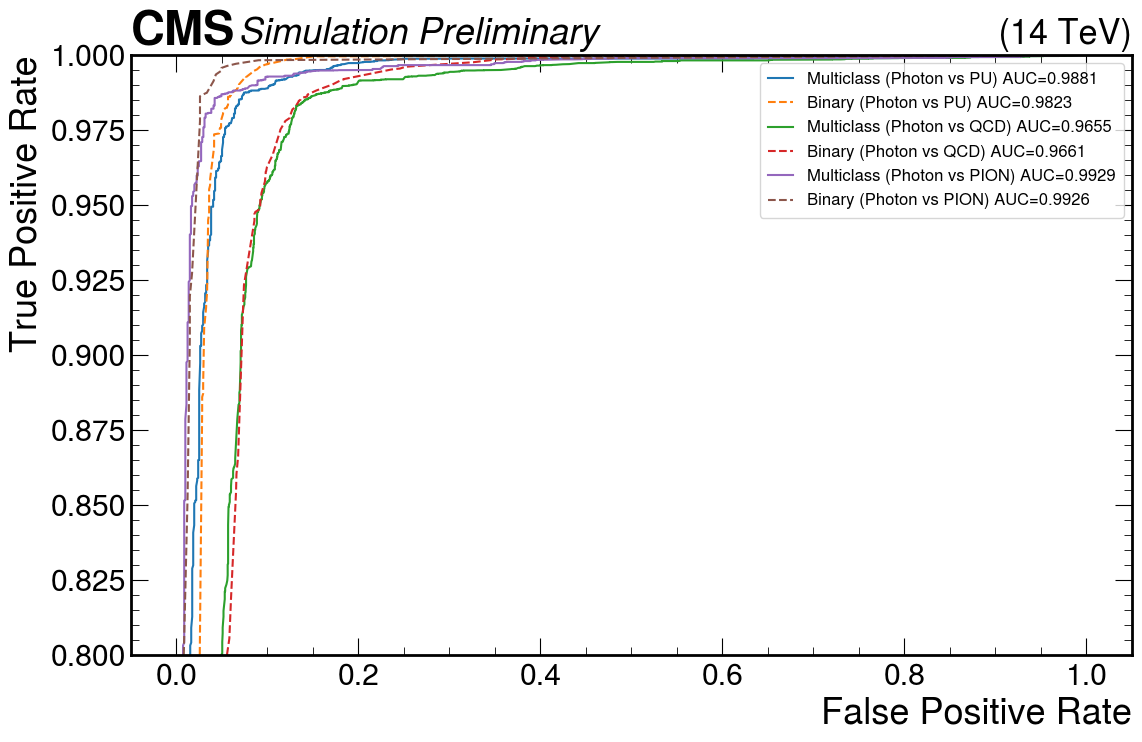

In [107]:
plt.figure(figsize=(12, 8))
proba_mc_test = model_multiclass.predict_proba(X_test)
for name, bkg in BKG.items():
    # select the SAME test events for that pair
    mask_te = (y_test == PHOTON) | (y_test == bkg)

    # truth for this pair: 1=photon, 0=bkg
    y_true = (y_test[mask_te] == PHOTON).astype(int)

    # multiclass photon score for those events
    score_mc = proba_mc_test[mask_te, PHOTON]

    # binary photon score on the same events
    X_te_pair = X_test[mask_te]
    score_bin = binary_models[name].predict_proba(X_te_pair)[:, 1]

    # ROC + AUC
    fpr_mc, tpr_mc, _ = roc_curve(y_true, score_mc)
    fpr_b,  tpr_b,  _ = roc_curve(y_true, score_bin)

    auc_mc = auc(fpr_mc, tpr_mc)
    auc_b  = auc(fpr_b,  tpr_b)

    plt.plot(fpr_mc, tpr_mc, label=f"Multiclass (Photon vs {name}) AUC={auc_mc:.4f}")
    plt.plot(fpr_b,  tpr_b,  linestyle="--", label=f"Binary (Photon vs {name}) AUC={auc_b:.4f}")

# diagonal
#plt.plot([0, 1], [0, 1], linestyle=":", linewidth=1)
#plt.yscale('log')
#plt.xscale('log')
plt.ylim(0.8,1.0)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=12, frameon=True)
mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit

plt.tight_layout()
plt.show()

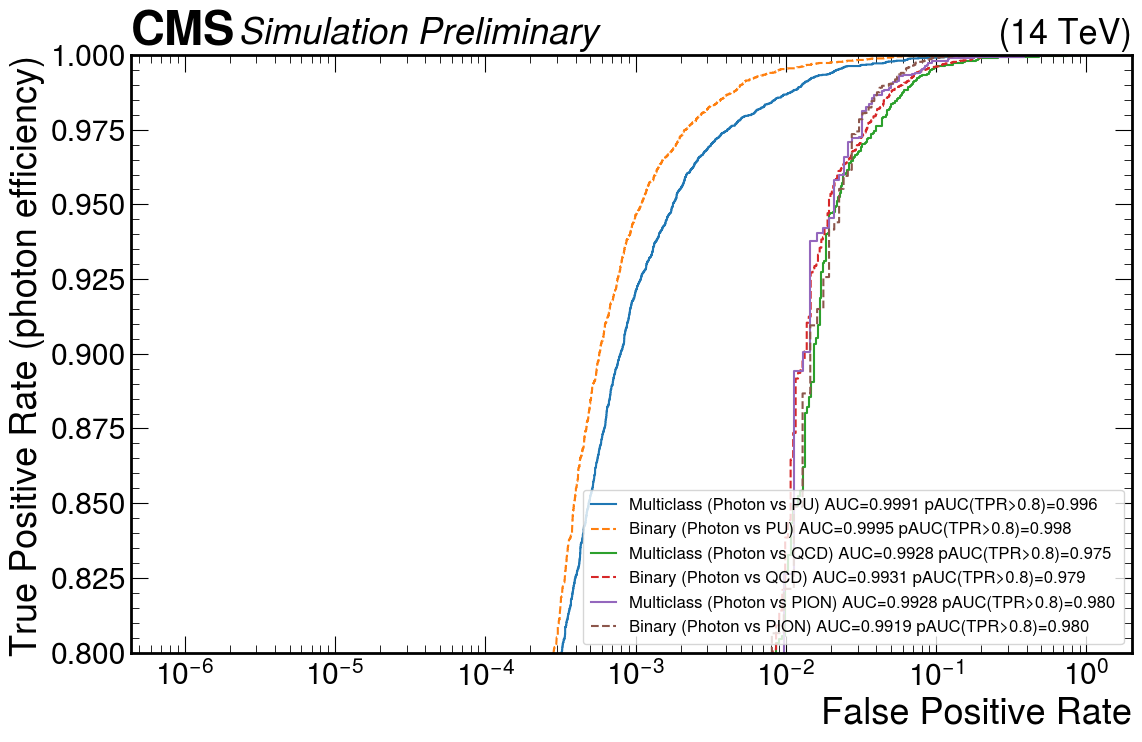

In [103]:
TPR_MIN = 0.8
def partial_auc_tpr_above(fpr, tpr, tpr_min=0.8):
    """
    Normalized partial AUC in [0,1] for the ROC region with TPR > tpr_min.
    Defined as area of (TPR - tpr_min) vs FPR, normalized by (1 - tpr_min).
    """
    fpr = np.asarray(fpr)
    tpr = np.asarray(tpr)
    excess = np.clip(tpr - tpr_min, 0.0, None)
    return auc(fpr, excess) / (1.0 - tpr_min)

def make_binary_dataset(X_in, y_in, bkg_label, photon_label=PHOTON):
    mask = (y_in == photon_label) | (y_in == bkg_label)
    X_sub = X_in[mask]
    y_sub = (y_in[mask] == photon_label).astype(int)  # 1=photon, 0=bkg
    return X_sub, y_sub, mask

def make_binary_model():
    return xgb.XGBClassifier(
        objective="binary:logistic",
        max_depth=5,
        n_estimators=50,
        learning_rate=0.1,
        eval_metric="logloss",
        n_jobs=8,
        verbosity=1
    )

# -----------------------
# 1) ONE split for fairness
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# -----------------------
# 2) Multiclass model (must be softprob to get probabilities)
# -----------------------
model_multiclass = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=4,
    max_depth=5,
    n_estimators=50,
    learning_rate=0.1,
    eval_metric="mlogloss",
    n_jobs=8,
    verbosity=1
)

w_mc = compute_sample_weight(class_weight="balanced", y=y_train)
model_multiclass.fit(X_train, y_train, sample_weight=w_mc)

proba_mc_test = model_multiclass.predict_proba(X_test)  # (N,4)

# -----------------------
# 3) Train 3 binary models (on TRAIN only)
# -----------------------
binary_models = {}
for name, bkg_lab in BKG.items():
    X_tr_sub, y_tr_sub, _ = make_binary_dataset(X_train, y_train, bkg_lab)
    w_tr_sub = compute_sample_weight(class_weight="balanced", y=y_tr_sub)

    m = make_binary_model()
    m.fit(X_tr_sub, y_tr_sub, sample_weight=w_tr_sub)
    binary_models[name] = m

# -----------------------
# 4) Plot: OvO ROCs (multiclass) + overlay binary, with pAUC in [0,1]
# -----------------------
plt.figure(figsize=(12, 8))

for name, bkg_lab in BKG.items():
    mask_te = (y_test == PHOTON) | (y_test == bkg_lab)
    y_true = (y_test[mask_te] == PHOTON).astype(int)  # 1=photon, 0=bkg

    # Multiclass photon score for those events
    score_mc = proba_mc_test[mask_te, PHOTON]

    # Binary photon score for those events
    X_te_pair = X_test[mask_te]
    score_bin = binary_models[name].predict_proba(X_te_pair)[:, 1]

    # ROC
    fpr_mc, tpr_mc, _ = roc_curve(y_true, score_mc)
    fpr_b,  tpr_b,  _ = roc_curve(y_true, score_bin)

    # Full AUC
    auc_mc = auc(fpr_mc, tpr_mc)
    auc_b  = auc(fpr_b,  tpr_b)

    # Partial AUC (normalized to [0,1])
    pauc_mc = partial_auc_tpr_above(fpr_mc, tpr_mc, tpr_min=TPR_MIN)
    pauc_b  = partial_auc_tpr_above(fpr_b,  tpr_b,  tpr_min=TPR_MIN)

    plt.semilogx(
        fpr_mc, tpr_mc,
        label=rf"Multiclass (Photon vs {name}) AUC={auc_mc:.4f} pAUC(TPR>{TPR_MIN})={pauc_mc:.3f}"
    )
    plt.semilogx(
        fpr_b, tpr_b, linestyle="--",
        label=rf"Binary (Photon vs {name}) AUC={auc_b:.4f} pAUC(TPR>{TPR_MIN})={pauc_b:.3f}"
    )

# Optional diagonal (avoid 0 on log-x)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (photon efficiency)")
plt.legend(fontsize=12, frameon=True)
plt.ylim(0.8,1.0)
mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit

plt.tight_layout()
plt.show()

In [132]:
explainer = shap.TreeExplainer(model_multiclass)
shap_values = explainer.shap_values(X_test)

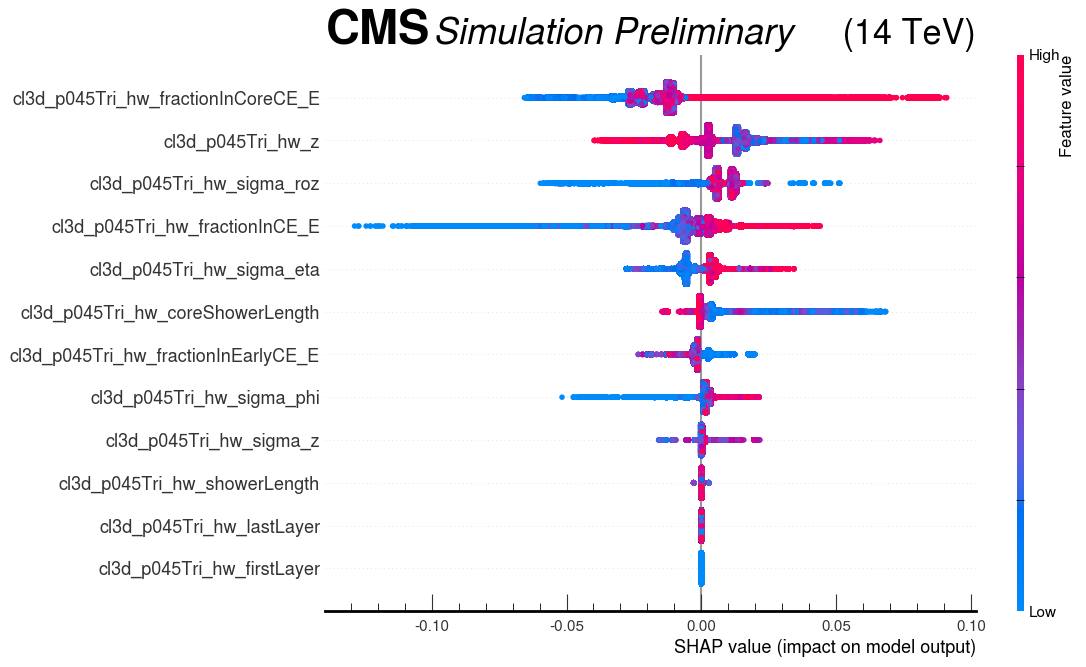

In [133]:
gamma_idx = 0 
pu_idx  = 1
qcd_idx = 2
pion_idx  = 3         
sv_gamma = shap_values[:, :, gamma_idx]
sv_pion  = shap_values[:, :, pion_idx]
sv_delta = sv_gamma - sv_pion
X_plot = X_test
shap.summary_plot(sv_delta, X_plot, feature_names=columns_for_training('p045Tri'), show=False)
fig = plt.gcf()
fig.set_size_inches(16,7)
mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit
plt.savefig("hardware_plots/SHAP_gamma_minus_pion_p045.pdf", bbox_inches="tight")
plt.show()


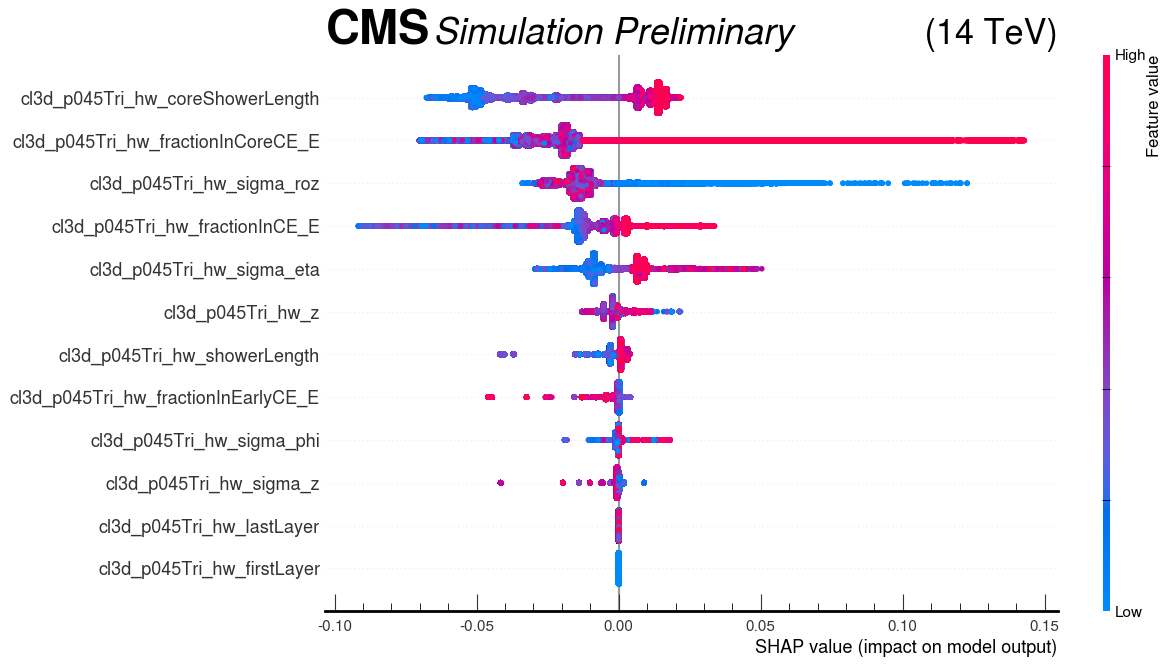

In [134]:
sv_gamma = shap_values[:, :, gamma_idx]
sv_pu  = shap_values[:, :, pu_idx]
sv_delta = sv_gamma - sv_pu
X_plot = X_test
shap.summary_plot(sv_delta, X_plot, feature_names=columns_for_training('p045Tri'), show=False)
fig = plt.gcf()
fig.set_size_inches(18,7)
mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit
plt.savefig("hardware_plots/SHAP_gamma_minus_PU200_p045.pdf", bbox_inches="tight")
plt.show()

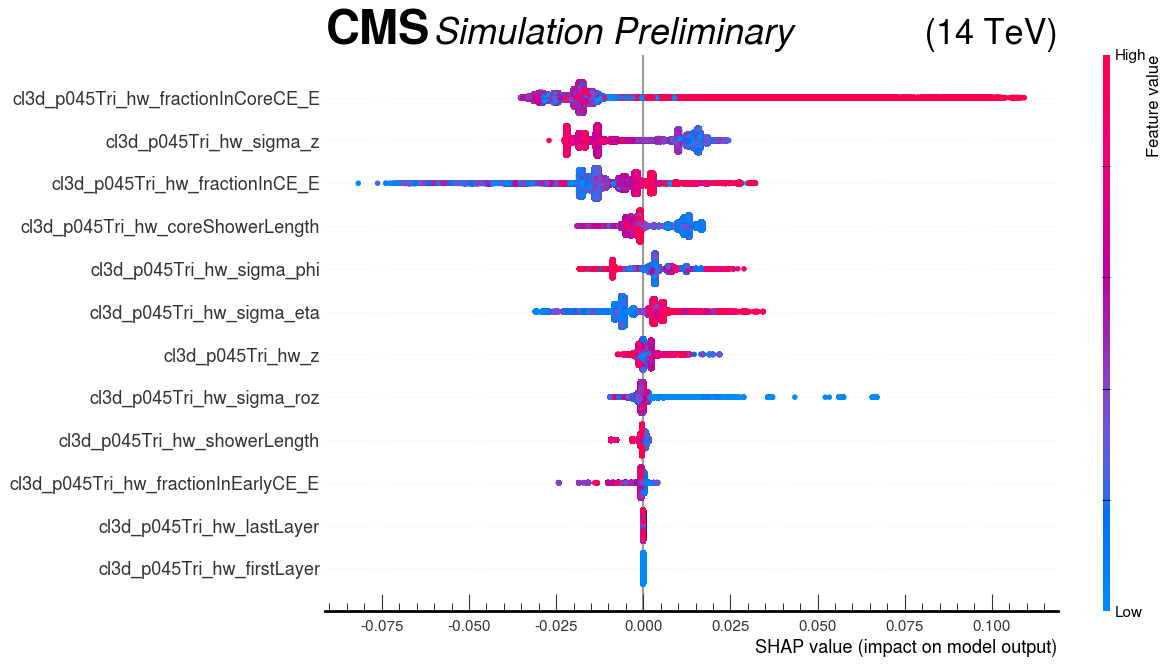

In [135]:
sv_gamma = shap_values[:, :, gamma_idx]
sv_qcd  = shap_values[:, :, qcd_idx]
sv_delta = sv_gamma - sv_qcd
X_plot = X_test
shap.summary_plot(sv_delta, X_plot, feature_names=columns_for_training('p045Tri'), show=False)
fig = plt.gcf()
fig.set_size_inches(18,7)
mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit
plt.savefig("hardware_plots/SHAP_gamma_minus_QCD_p045.pdf", bbox_inches="tight")
plt.show()

In [83]:
def plot_across_five_lists(
    df_ref, df_p0113, df_p016, df_p03, df_p045,
    vars_ref, vars_p0113, vars_p016, vars_p03, vars_p045,
    label_ref="Ref", label_p0113="p=0.113", label_p016="p=0.16", label_p03="p=0.30", label_p045="p=0.45",
    plots_dir="plots_triangles", var_latex_map=None, num_bins=40, cl3d_pt_range=(20, 200),
    pt_col_ref="cl3d_Ref_pt", pt_col_p0113="cl3d_p0113Tri_pt", pt_col_p016="cl3d_p016Tri_pt",
    pt_col_p03="cl3d_p03Tri_pt", pt_col_p045="cl3d_p045Tri_pt",
    density=False, logy=False, weight_cols=None
):
    os.makedirs(plots_dir, exist_ok=True)
    if var_latex_map is None:
        var_latex_map = {}
    suffix_labels = ana.var_map_suffix()
    # Build maps: suffix -> full col name (for each DF)
    def suffix(name): 
        return name.split("_", maxsplit=2)[-1] if name.count("_")>=2 else name

    by_suffix = {"ref":{}, "p0113":{}, "p016":{}, "p03":{}, "p045":{}}
    for c in vars_ref:  by_suffix["ref"][suffix(c)]  = c
    for c in vars_p0113: by_suffix["p0113"][suffix(c)] = c
    for c in vars_p016: by_suffix["p016"][suffix(c)] = c
    for c in vars_p03:  by_suffix["p03"][suffix(c)]  = c
    for c in vars_p045: by_suffix["p045"][suffix(c)] = c

    # Union of all suffixes to try plotting
    all_suffixes = list(dict.fromkeys(
        list(by_suffix["ref"].keys()) +
        list(by_suffix["p0113"].keys()) +
        list(by_suffix["p016"].keys()) +
        list(by_suffix["p03"].keys()) +
        list(by_suffix["p045"].keys())
    ))

    # Helper to get (series, weights) after pT window for a given variant
    def select(df, col, pt_col, wcol):
        if (col not in df.columns) or (pt_col not in df.columns): 
            return pd.Series(dtype=float), None
        m = (df[pt_col] >= cl3d_pt_range[0]) & (df[pt_col] <= cl3d_pt_range[1])
        ser = df.loc[m, col].dropna()
        w = (df.loc[m, wcol] if (wcol and wcol in df.columns) else None)
        if w is not None: w = w.loc[ser.index]
        return ser, w

    # Iterate each suffix (i.e., each physics variable)
    for suf in all_suffixes:
        cols = {
            "ref":  by_suffix["ref"].get(suf,  None),
            "p0113": by_suffix["p0113"].get(suf, None),
            "p016": by_suffix["p016"].get(suf, None),
            "p03":  by_suffix["p03"].get(suf,  None),
            "p045": by_suffix["p045"].get(suf, None),
        }

        # Gather data
        s_ref,  w_ref  = select(df_ref,  cols["ref"],  pt_col_ref,  (weight_cols or {}).get("ref"))
        s_p0113, w_p0113 = select(df_p0113, cols["p0113"], pt_col_p0113, (weight_cols or {}).get("p0113"))
        s_p016, w_p016 = select(df_p016, cols["p016"], pt_col_p016, (weight_cols or {}).get("p016"))
        s_p03,  w_p03  = select(df_p03,  cols["p03"],  pt_col_p03,  (weight_cols or {}).get("p03"))
        s_p045, w_p045 = select(df_p045, cols["p045"], pt_col_p045, (weight_cols or {}).get("p045"))

        series_list = [s for s in [s_ref, s_p0113, s_p016, s_p03, s_p045] if not s.empty]
        if not series_list:
            print(f"[skip] No data for '{suf}' after pT filter.")
            continue

        # Binning: integer bins if all are integer-like, else uniform numeric bins
        mins = [s.min() for s in series_list]
        maxs = [s.max() for s in series_list]
        all_int = all(is_integer_dtype(s) for s in series_list)
        gmin, gmax = float(np.min(mins)), float(np.max(maxs))
        if all_int and np.isfinite(gmin) and np.isfinite(gmax):
            bin_edges = np.arange(np.floor(gmin)-0.5, np.ceil(gmax)+1.5, 1.0)
        else:
            if gmin == gmax:
                gmin -= 0.5; gmax += 0.5
            bw = (gmax - gmin) / float(num_bins)
            bin_edges = np.arange(gmin - bw/2, gmax + bw/2 + 1e-12, bw)

        # Plot
        plt.figure(figsize=(10,6))
        if not s_ref.empty:
            plt.hist(s_ref.values,  bins=bin_edges, histtype="step", label=label_ref,  density=density, weights=(w_ref.values if w_ref is not None else None))
        if not s_p0113.empty:
            plt.hist(s_p0113.values, bins=bin_edges, histtype="step", label=label_p0113, density=density, weights=(w_p0113.values if w_p0113 is not None else None))
        if not s_p016.empty:
            plt.hist(s_p016.values, bins=bin_edges, histtype="step", label=label_p016, density=density, weights=(w_p016.values if w_p016 is not None else None))
        if not s_p03.empty:
            plt.hist(s_p03.values,  bins=bin_edges, histtype="step", label=label_p03,  density=density, weights=(w_p03.values if w_p03 is not None else None))
        if not s_p045.empty:
            plt.hist(s_p045.values, bins=bin_edges, histtype="step", label=label_p045, density=density, weights=(w_p045.values if w_p045 is not None else None))

        # Labels
        sample_full = next((c for c in [cols["ref"], cols["p0113"], cols["p016"], cols["p03"], cols["p045"]] if c is not None), None)
        suf_label   = suffix_labels.get(suf)  # e.g. 'pt' -> '$p_T$ [GeV]'
        x_label     = suf_label or (var_latex_map or {}).get(sample_full, suf)
        plt.xlabel(x_label)
        plt.yscale('log')
        plt.ylabel("# Clusters")
        plt.legend(loc='best')
        plt.tight_layout()
        fig = plt.gcf()
        mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit
        out = os.path.join(plots_dir, f"{suf}_across_triangles.pdf")
        plt.savefig(out)
        print(f"Saved: {out}")
        plt.show()
        plt.close()

In [136]:
def plot_histograms(df_signal, df_bg1, df_bg2, df_bg3, variables, label_signal, label_bg1, label_bg2, label_bg3, plots_dir, var_latex_map, prefix, num_bins=40, figsize=(12, 8)):
    for var in variables:
        plt.figure(figsize=figsize)
        min_value = min(df_signal[var].min(), df_bg1[var].min(), df_bg2[var].min(), df_bg3[var].min())
        max_value = max(df_signal[var].max(), df_bg1[var].max(), df_bg2[var].max(), df_bg3[var].max())
        bin_edges = np.arange(min_value - 0.5, max_value + 1.5, 1)
        '''else:
            min_value = min(df_signal[var].min(), df_bg1[var].min(), df_bg2[var].min(), df_bg3[var].min())
            max_value = max(df_signal[var].max(), df_bg1[var].max(), df_bg2[var].max(), df_bg3[var].max())
            bin_width = (max_value - min_value) / num_bins
            bin_edges = np.arange(min_value - bin_width / 2, max_value + bin_width / 2, bin_width)'''
        plt.hist(df_signal[var], histtype='step', bins=bin_edges, color='b', linewidth=1.5, label=label_signal, density=True)
        plt.hist(df_bg1[var], histtype='step', bins=bin_edges, color='g', linewidth=1.5, label=label_bg1, density=True)
        plt.hist(df_bg2[var], histtype='step', bins=bin_edges, color='r', linewidth=1.5, label=label_bg2, density=True)
        plt.hist(df_bg3[var], histtype='step', bins=bin_edges, color='black', linewidth=1.5, label=label_bg3, density=True)
        plt.xlabel(var_latex_map.get(var, var))
        plt.ylabel('# Events (normalised)')
        plt.legend()
        plt.tight_layout(rect=[0, 0, 1, 0.92])
        fig = plt.gcf()
        mh.cms.label("Preliminary", data=False, com=14) 
        filename = os.path.join(plots_dir, f"{var}_histogram_p045.pdf")
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")
        plt.show()
        plt.close()

Saved: hardware_plots/cl3d_p045Tri_hw_showerLength_histogram_p045.pdf


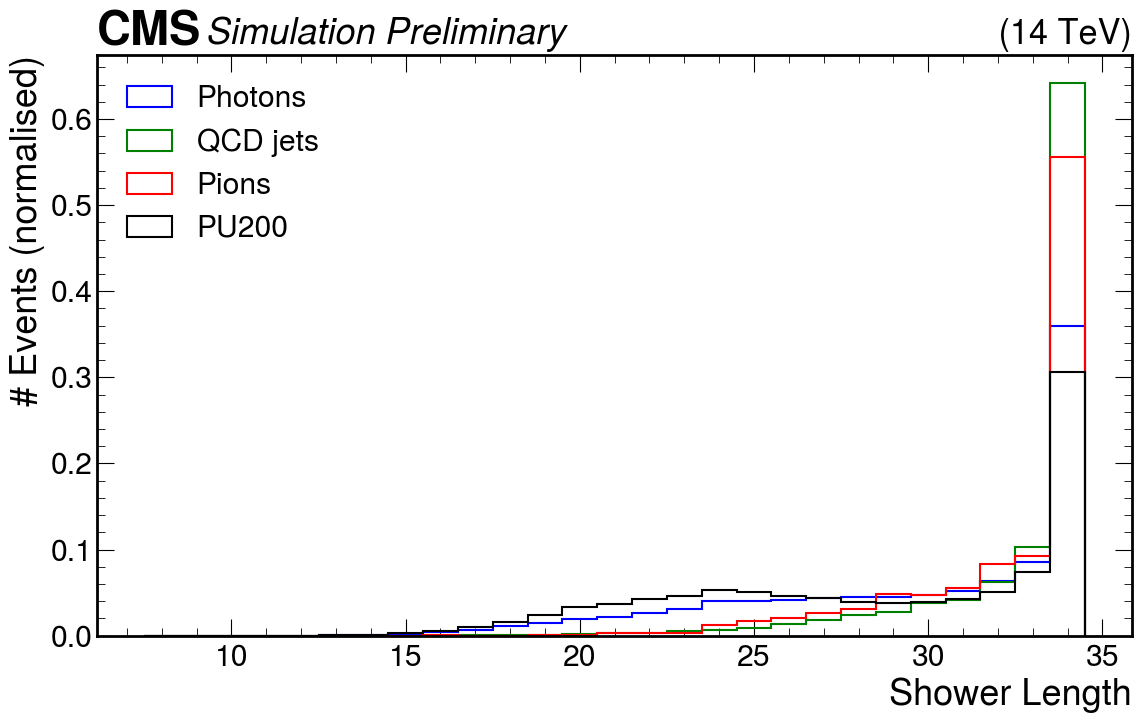

Saved: hardware_plots/cl3d_p045Tri_hw_coreShowerLength_histogram_p045.pdf


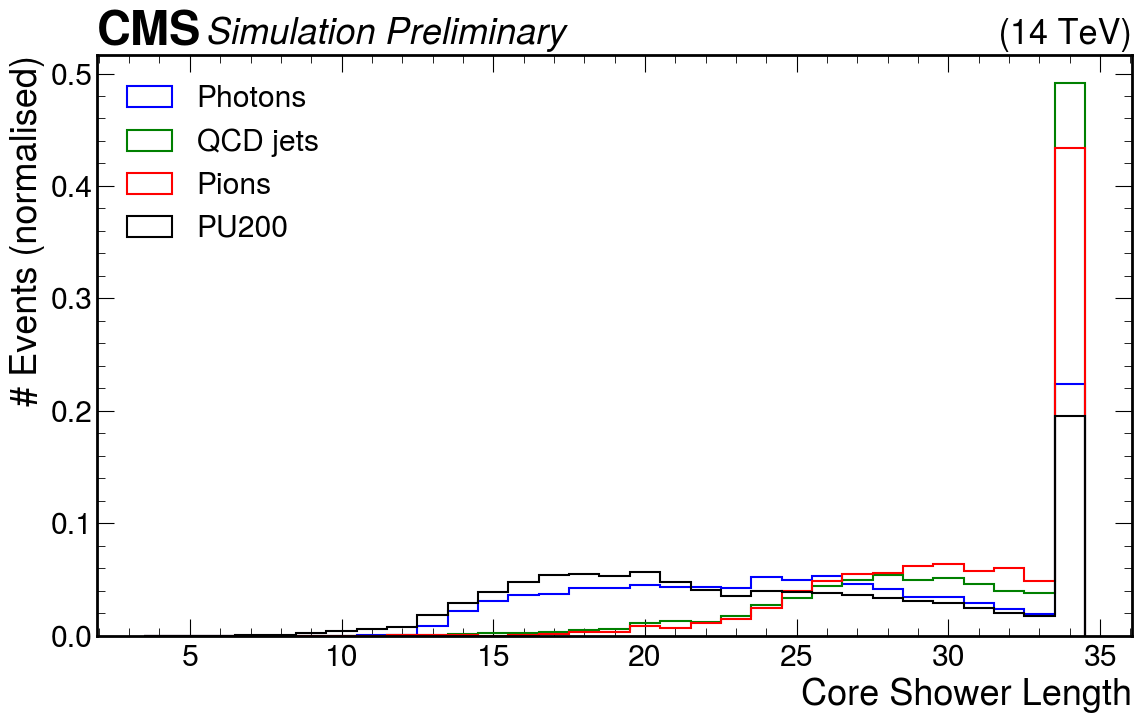

Saved: hardware_plots/cl3d_p045Tri_hw_firstLayer_histogram_p045.pdf


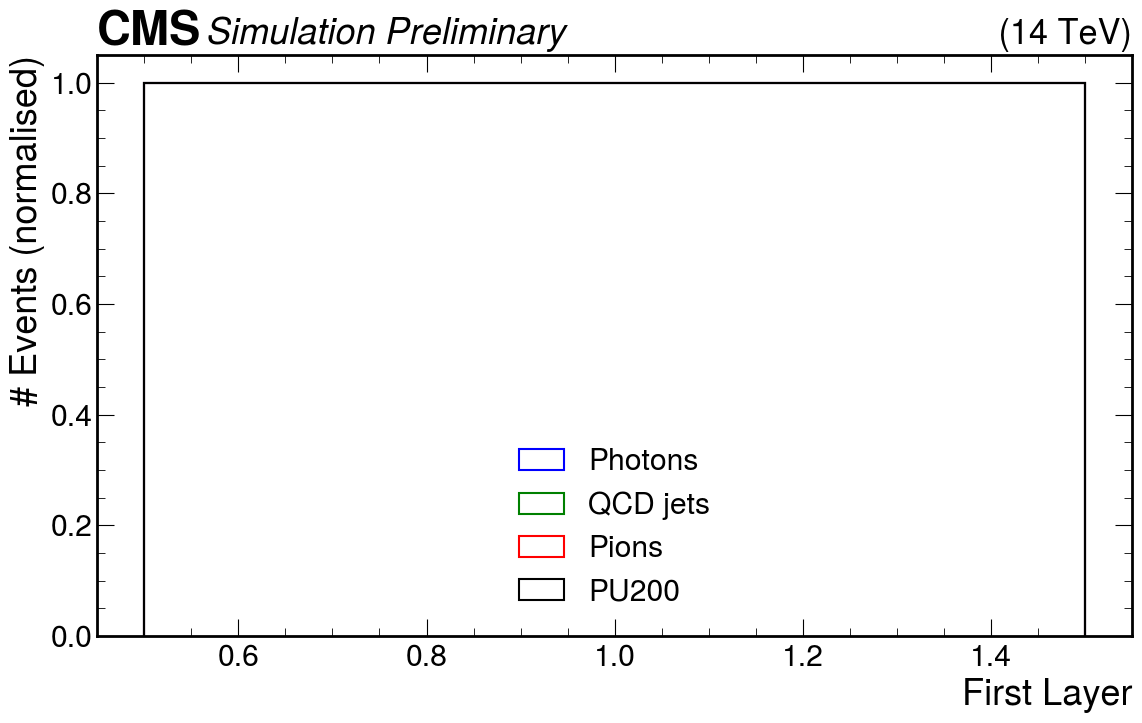

Saved: hardware_plots/cl3d_p045Tri_hw_lastLayer_histogram_p045.pdf


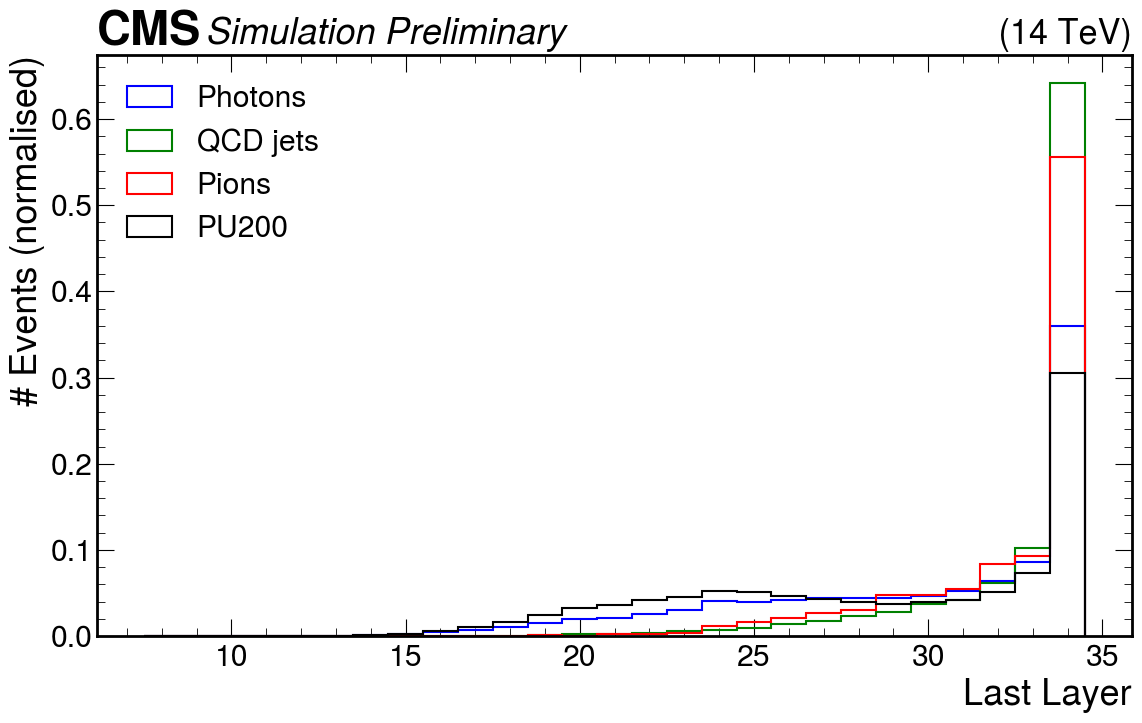

Saved: hardware_plots/cl3d_p045Tri_hw_z_histogram_p045.pdf


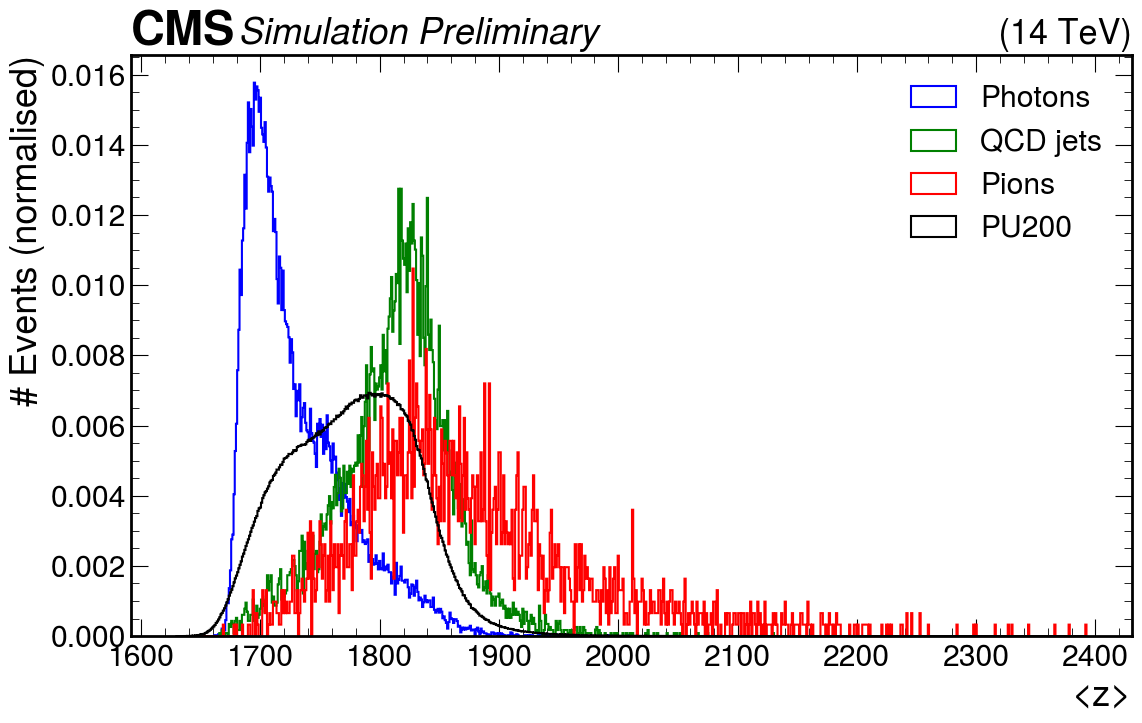

Saved: hardware_plots/cl3d_p045Tri_hw_sigma_roz_histogram_p045.pdf


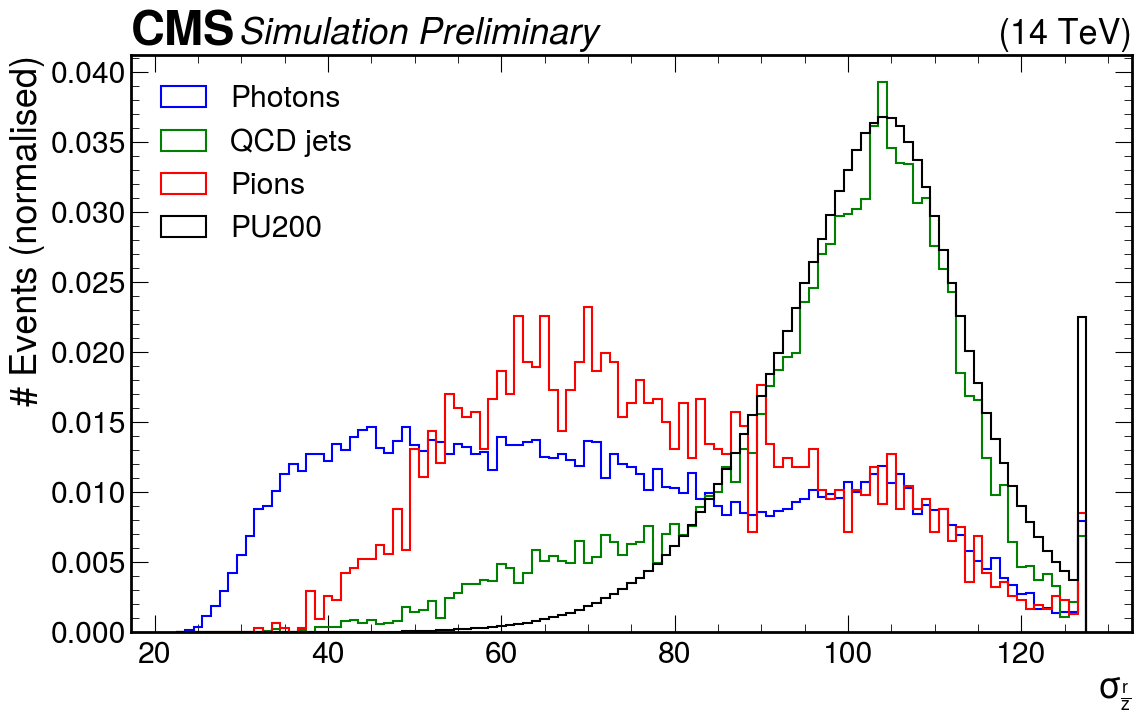

Saved: hardware_plots/cl3d_p045Tri_hw_sigma_eta_histogram_p045.pdf


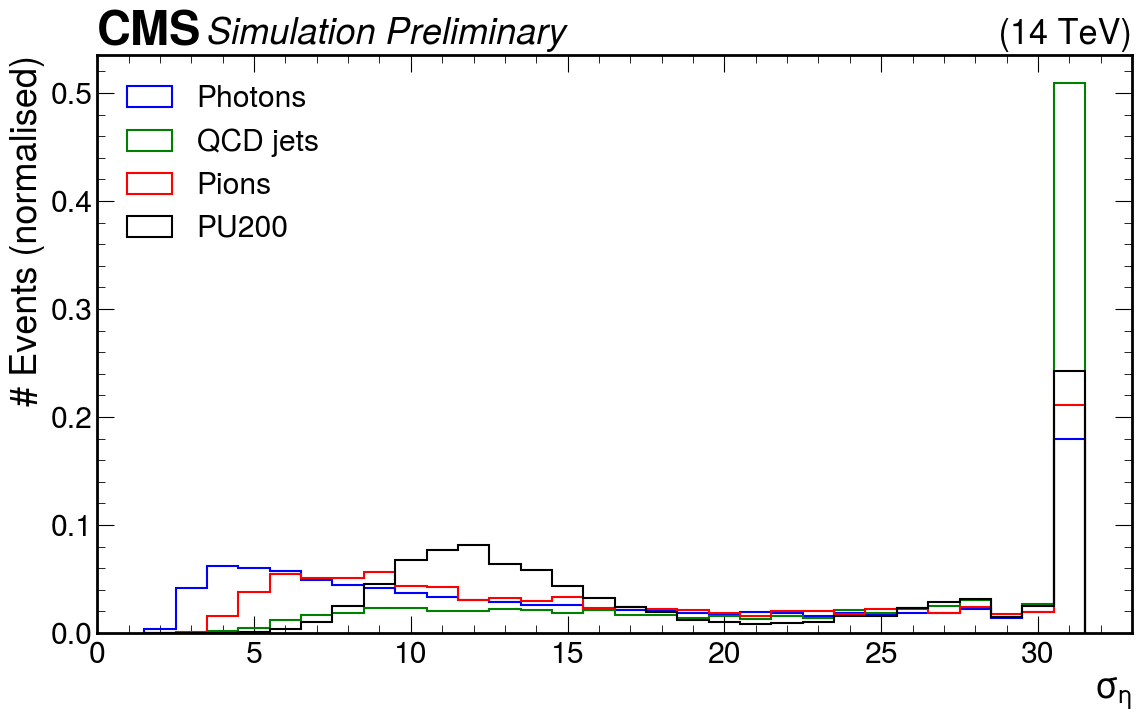

Saved: hardware_plots/cl3d_p045Tri_hw_sigma_phi_histogram_p045.pdf


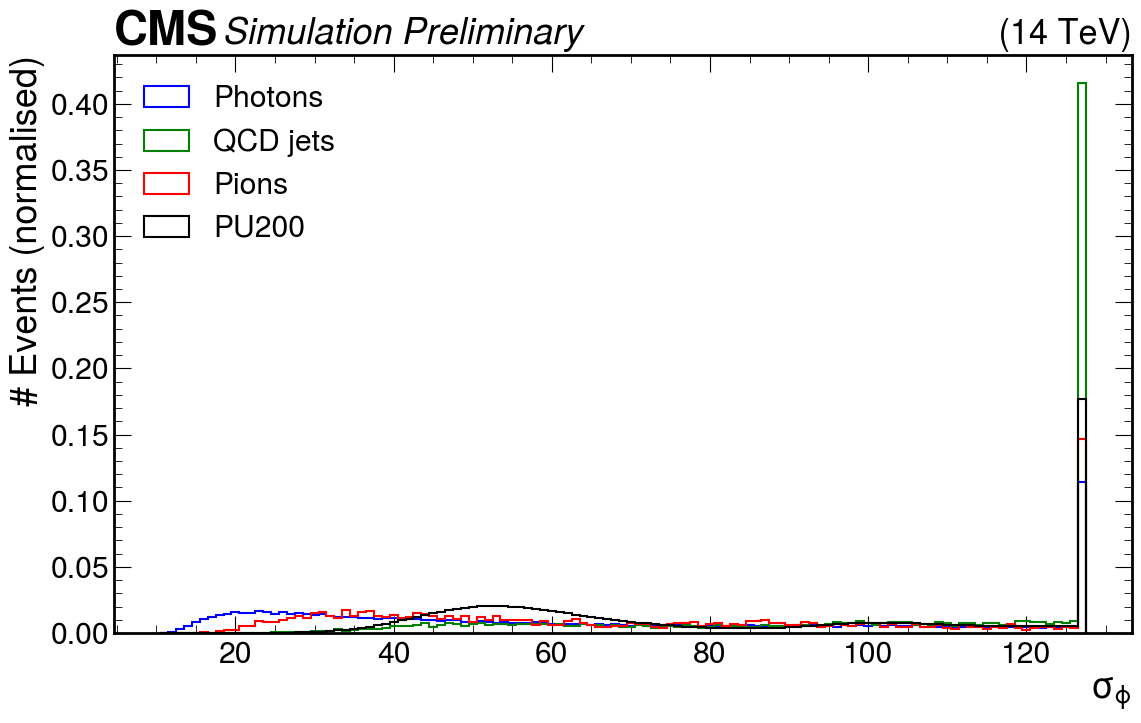

Saved: hardware_plots/cl3d_p045Tri_hw_sigma_z_histogram_p045.pdf


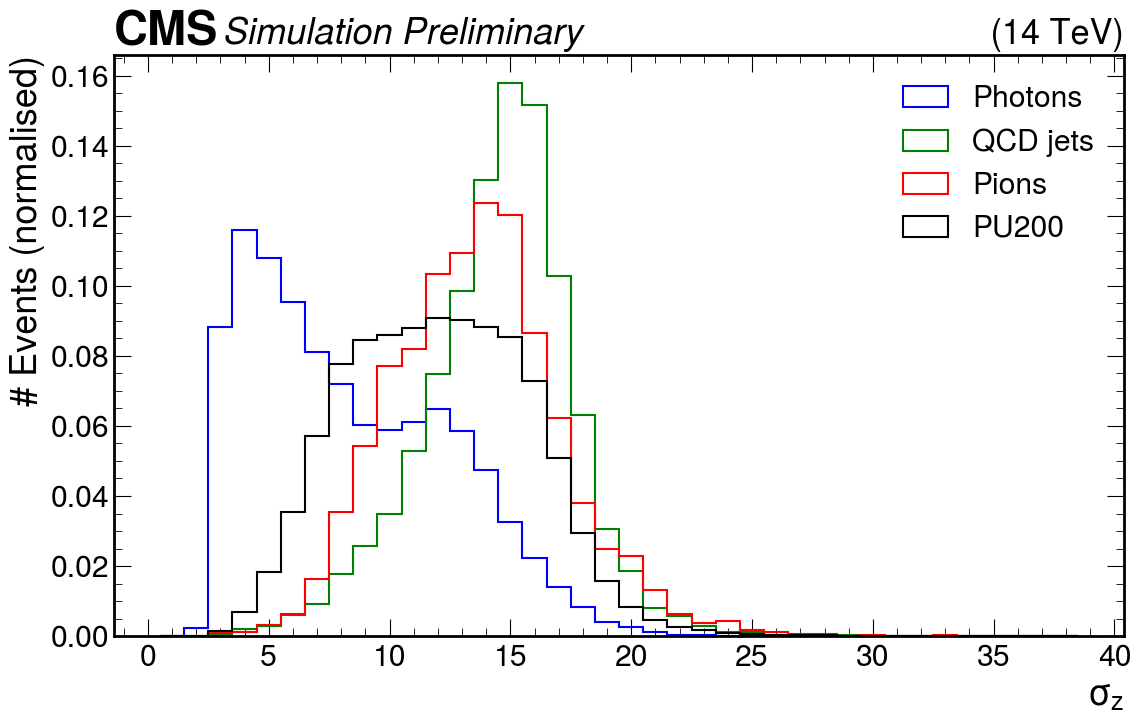

Saved: hardware_plots/cl3d_p045Tri_hw_fractionInCE_E_histogram_p045.pdf


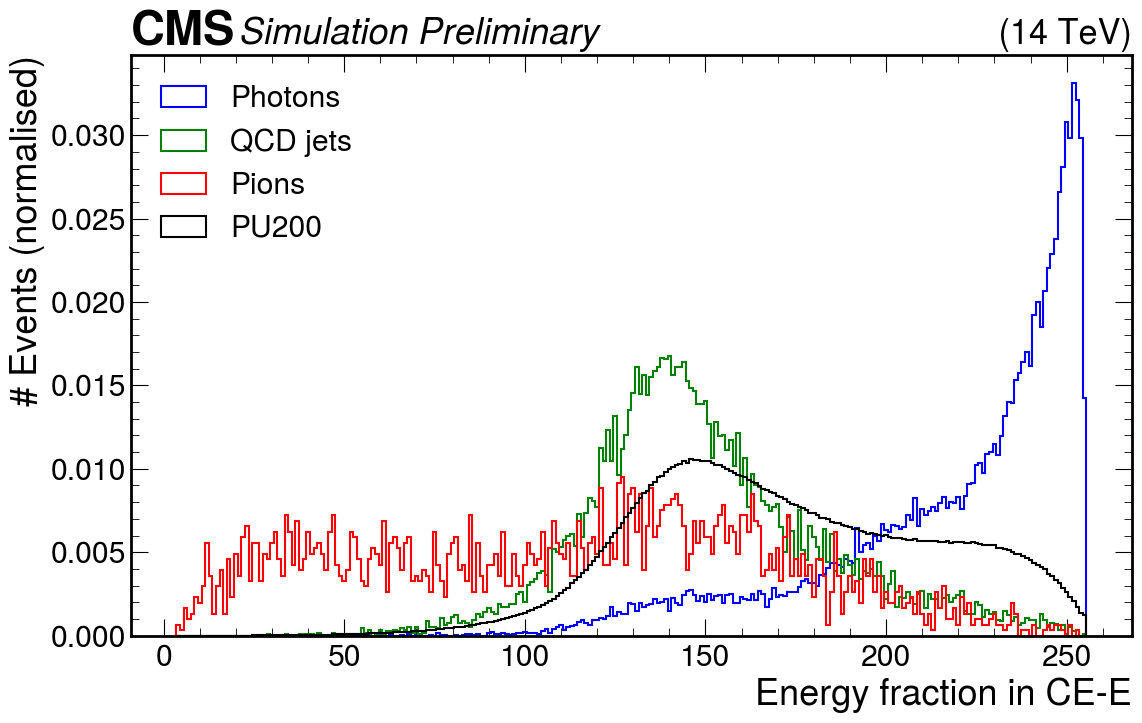

Saved: hardware_plots/cl3d_p045Tri_hw_fractionInCoreCE_E_histogram_p045.pdf


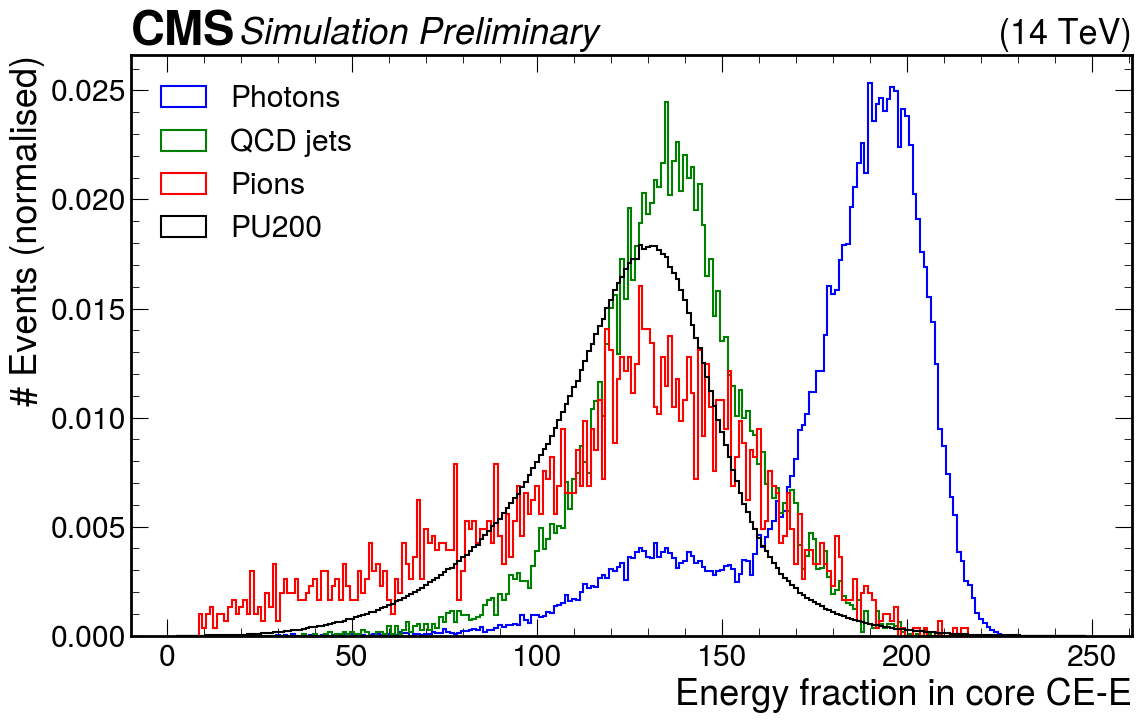

Saved: hardware_plots/cl3d_p045Tri_hw_fractionInEarlyCE_E_histogram_p045.pdf


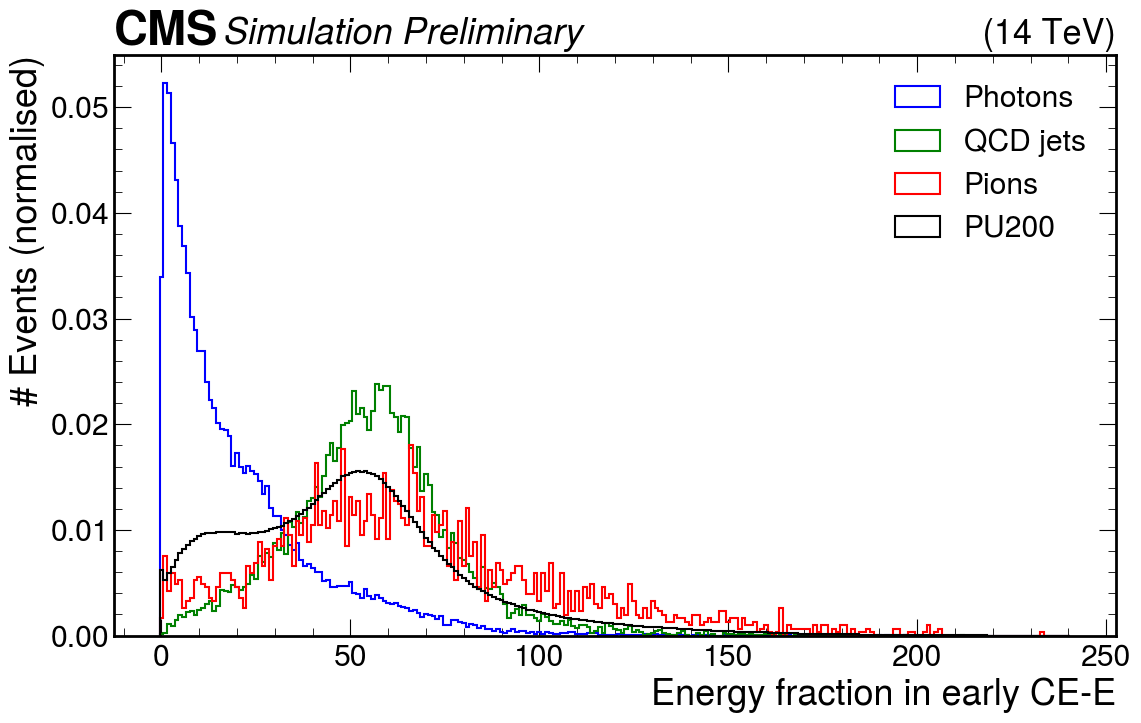

In [137]:
plot_histograms(photon_df_p045_filtered, qcd_df_p045_filtered, pion_df_p045_filtered, PU_df_p045, columns_for_training('p045Tri'), "Photons", 'QCD jets', 'Pions', 'PU200', 'hardware_plots', var_map('p045Tri'), 'p045Tri')